In [1]:
# uncomment the following commands when running in google colab
#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
import time

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [4]:
import matplotlib.pyplot as plt

In [5]:
import gc # for clearing garbage from RAM

In [6]:
current_dir=os.getcwd()
print(current_dir)

C:\Users\agarw\Downloads\udacity-mlnd-master\Capstone project


In [7]:
print(os.listdir())

['.ipynb_checkpoints', 'CHAMPS_rel_pos.csv', 'interatomic_distances.ipynb', 'nearest_neighbors.ipynb', 'predicting_scalar_couplings_II.ipynb', 'predictions_v2', 'Proposal Review.pdf', 'Proposal.pdf', 'README.md', 'Report.pdf', 'sample_data', 'sample_submissions', 'SavedModels', 'structures_sample.csv', 'test_sample.csv', 'tex files', 'train_sample.csv']


# EDA

In [8]:
# importing train, test and structures
train=pd.read_csv("train_sample.csv", index_col='id')
test=pd.read_csv("test_sample.csv", index_col='id')
struct=pd.read_csv("structures_sample.csv")

In [9]:
# Checking for missing values in train.csv
train.isnull().values.any()

False

In [10]:
# Checking missing values in test.csv
test.isnull().values.any()

False

In [11]:
# Checking missing values in structures.csv
struct.isnull().values.any()

False

From above, we see that there are no NaN's in either of the files. 

In [12]:
struct.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000658,0,C,-0.021929,1.528323,0.044394
1,dsgdb9nsd_000658,1,C,1.407899,2.085425,-0.014287
2,dsgdb9nsd_000658,2,C,2.164123,1.564454,-1.245427
3,dsgdb9nsd_000658,3,C,2.156834,0.029517,-1.301592
4,dsgdb9nsd_000658,4,C,0.727005,-0.527586,-1.242911


In [13]:
train.head(11)

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
18272,dsgdb9nsd_000948,7,0,1JHN,61.042200
18273,dsgdb9nsd_000948,7,1,2JHC,1.460880
18274,dsgdb9nsd_000948,7,2,3JHN,3.473880
18275,dsgdb9nsd_000948,7,6,3JHN,-0.179600
18276,dsgdb9nsd_000948,7,8,2JHH,6.995330
18277,dsgdb9nsd_000948,8,0,1JHN,61.042200
18278,dsgdb9nsd_000948,8,1,2JHC,1.460890
18279,dsgdb9nsd_000948,8,2,3JHN,-0.179603
18280,dsgdb9nsd_000948,8,6,3JHN,3.473880


The first 10 rows of the training data set correspond to the same molecule, here labeled as "dsgdb9nsd_000001". We can find information about its constituent atoms by looking at the "structures" file and picking out the rows that have "dsgdb9nsd_000001" as the entry for the "molecule_name" column.  

In [14]:
# use pandas.Dataframe.loc to access the instances that satisfy a particular condition
# here we want to get the rows having "dsgdb9nsd_000001" as their "molecule_name" 
struct.loc[struct['molecule_name']=="dsgdb9nsd_000001"]

,molecule_name,atom_index,atom,x,y,z


By looking at the first 5 rows in the "structures" file, we can also see that "dsgdb9nsd_000001" consists of 5 atoms: 1 Carbon (C) atom and 4 Hydrogen (H) atom. It is reasonable to guess that this is a  𝐶𝐻4  molecule. Note that in the  𝐶𝐻4  molecule, all the 4 hydrogen atoms are equivalent, so we would expect their properties to be the same. This is further confirmed from the training data by noticing that the coupling constant between any two hydrogen atoms is almost the same, being equal to  ∼−11.25 . Similarly, the coupling constant between the carbon atom and any of the hydrogen atoms is approximately  ∼84.80 .

Having established that "dsgdb9nsd_000001" is  𝐶𝐻4 , we can use this to undestand the entries in the column labeled "type" in the "train" file: we notice that the format of the entries under this column is "nJAtom1Atom2" for e.g., 1JHC, 2JHH, 1JNH etc. By comparing to the molecular structure of  𝐶𝐻4  as shown here, we realize that the notation "nJAtom1Atom2", that there are "n-links" between Atoms1 and Atom2, or in otherwords, one has to take n-steps as one goes from Atom1 to Atom2. For e.g. There is a single link between the carbon atom and any of the hydrogen atoms. It therefore implies that we need exactly 1 step to go from the carbon atom to any of the hydrogen atoms or vice-versa. Thus the "type" should be 1JHC which is indeed the case for "dsgdb9nsd_000001". Similarly, in  𝐶𝐻4 , we will have to take exactly 2 steps to go from one hydrogen atom to another hydrogen atom. Thus the corresponding type should be 2JHH for any pair of hydrogen atoms. Again, this is the case for "dsgdb9nsd_000001".

We also notice that the symmetry between the hydrogen atoms of  𝐶𝐻4  requires all their coupling constants to be exactly the same. However, we notice that they are equal only upto 2 decimal places. Thus, we shouldn't expect the machine learning algorithms trained on this data to produce results that are accurate at more than 2 decimal places.

The only categorical feature in train/test is 'type'. Let us check how many different values can it take. 

In [15]:
train.type.unique()

array(['1JHN', '2JHC', '3JHN', '2JHH', '3JHC', '2JHN', '1JHC', '3JHH'],
      dtype=object)

We see that it can take 8 different values: 1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN

Let us also checkout the number of samples for each type in both training and test set

In [16]:
train['type'].describe()

count     54983
unique        8
top        3JHC
freq      17799
Name: type, dtype: object

In [17]:
test.type.describe()

count     32918
unique        8
top        3JHC
freq      10740
Name: type, dtype: object

In [18]:
train['type'].value_counts()

3JHC    17799
2JHC    13449
1JHC     8400
3JHH     7006
2JHH     4492
3JHN     1949
2JHN     1394
1JHN      494
Name: type, dtype: int64

In [19]:
test.type.value_counts()

3JHC    10740
2JHC     8012
1JHC     5004
3JHH     4141
2JHH     2637
3JHN     1184
2JHN      906
1JHN      294
Name: type, dtype: int64

These can be easily visulized through a histogram

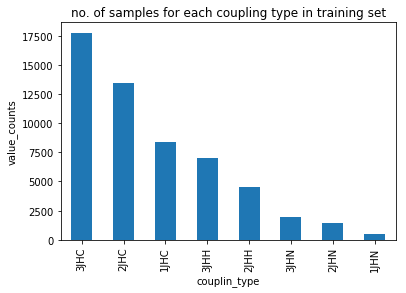

In [20]:
plt.figure()
train['type'].value_counts().plot(kind='bar')
plt.xlabel('couplin_type')
plt.ylabel('value_counts')
plt.title('no. of samples for each coupling type in training set')
plt.show()

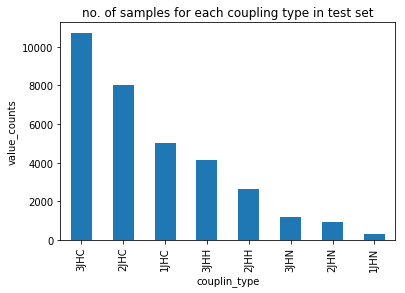

In [21]:
plt.figure()
test['type'].value_counts().plot(kind='bar')
plt.xlabel('couplin_type')
plt.ylabel('value_counts')
plt.title('no. of samples for each coupling type in test set')
plt.show()

From above we see that that  8 different 'types' of couplings, with 3JHC being the most frequent and 1JHN being the least frequent. 

Let us now consider the distribution of the target variable i.e. scalar_coupling_constant in the training set

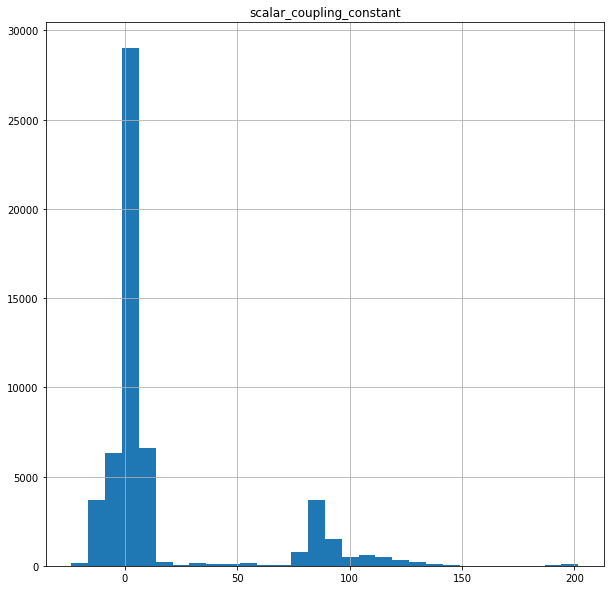

In [22]:
hist_all=train.hist( column='scalar_coupling_constant', figsize=(10,10), bins=30)

We see that most of the values lie betweeen ~ -25 to 25, with a small fraction between the range ~ 75 to 150. A very small number also lies around the value 200. Let's see how these values are distributed when classified by the coupling type. 

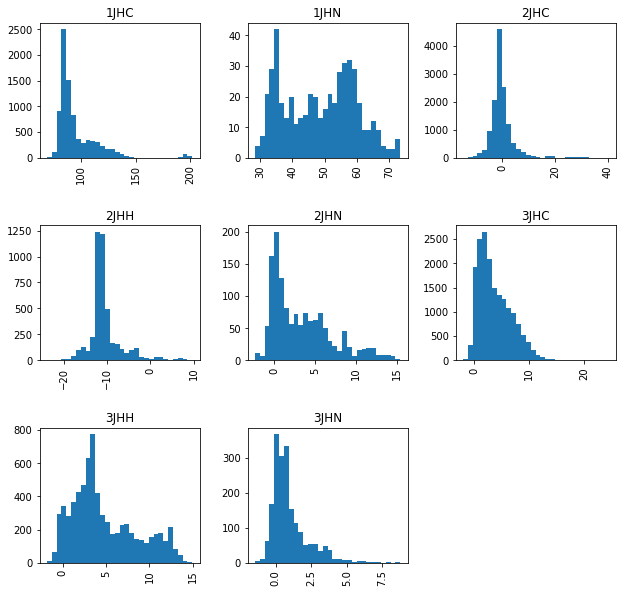

In [23]:
# see this link for tips on using pandas histogram: 
# https://mode.com/example-gallery/python_histogram/
hist_grouped_by_type=train.hist( column='scalar_coupling_constant', 
                                by='type', figsize=(10,10), bins=30)

We notice that the distribution of the coupling constants varies quite a bit across the different types. For e.g. the distribution is more or less gaussian for type 2JHC and 2JHH, however for the type 1JHN it seems to contain two overlapping gaussians. Similarly, the range of values taken by the coupling constant also varies quite a bit with the coupling type. For e.g., the coupling constants in type 2JHC seem to be normally  distributed between $\sim -15$ to $15$ with a small number of outliers around $\sim 20$ and also around $\sim 30$. On the other hand, the values for type 1JHC appear to mostly lie between $\sim 50$ to $\sim 150$ with a few outliers around $200$. Similarly, the values for type 2JHH are mostly negative while that for type 3JHH are mostly positive. This suggest that it is perhaps best to build independent models for each type, such that they are able to best capture the individual characteristics that are at play in each individual type.

Let us look at some more detailed statistics about the distribution of these coupling constants

In [24]:
train.groupby(['type']).scalar_coupling_constant.describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
1JHC,8400.0,94.994716,18.474161,68.62830,83.986725,88.025400,100.748500,201.76100
1JHN,494.0,48.581487,10.999363,28.46700,38.389200,49.510550,57.348825,73.40710
2JHC,13449.0,-0.271832,4.569249,-15.06850,-2.280860,-0.960929,0.906626,40.29650
2JHH,4492.0,-10.416022,3.934645,-23.85510,-12.033125,-11.359700,-9.763185,9.63316
2JHN,1394.0,3.349167,3.730883,-2.38434,0.241342,2.287535,5.471495,15.45740
3JHC,17799.0,3.674286,3.002705,-2.08774,1.338285,2.874970,5.653610,24.38370
3JHH,7006.0,4.743854,3.720631,-1.81848,2.058725,3.606570,7.253050,14.93090
3JHN,1949.0,0.982242,1.299452,-1.47290,0.124590,0.640389,1.421200,8.77682


We can visualize the above statistics through a box plot

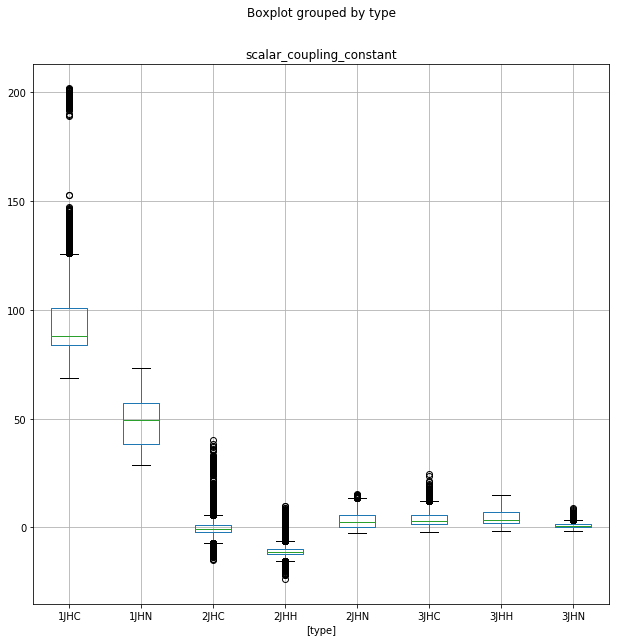

In [25]:
# understanding boxplots: https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51
# tips on boxplot in pandas and seaborn: http://cmdlinetips.com/2018/03/how-to-make-boxplots-in-python-with-pandas-and-seaborn/
bx_plt=train.boxplot(column=['scalar_coupling_constant'], by = ['type'], figsize=(10,10))

## Splitting the data into training and validation set

We will split according to the different molecules. Thus of all the training molecules, we will separate out a randomly chosen 20% subset of molecules for cross-validation puposes

In [26]:
training_file='train_sample.csv'
test_file='test_sample.csv'

In [27]:
train=pd.read_csv(training_file, index_col='id')

In [28]:
test=pd.read_csv(test_file)

In [29]:
molecules=train.molecule_name.unique()
print(len(molecules))

1000


In [30]:
# choosing a random subset of n_molecules_val for validation set
# in order to prevent leakage of information between various runs (due ot reloading of weights), we will never 
# change the seed used here to select the validation set (seed = 1764)
np.random.seed(1764)
val_percent = 20 # percentage of molecules in validation set
n_molecules=val_percent*len(molecules)//100
val_molecules=np.random.choice(molecules, size=n_molecules, replace=False)

In [31]:
len(val_molecules)

200

In [32]:
# removing the validation set molecules from the rest 
train_molecules=np.setdiff1d(molecules, val_molecules, assume_unique=True)
len(train_molecules)

800

# Feature Engineering

Note that we had seperately created files that contain information about the neigbors of the atoms involved in the coupling. Here we will use this information to engineer various useful features for us. This will inverse powers of the distance to nearest neighbors.

Also, note that this process results in extremely large data and takes quite a bit of time. Therefore, for demonstration purposes we will henceforth work with only a small subset of sample data.  

In [33]:
# the following function takes type of the coupling as input 
# it then return a DataFrame containing the following features
# distances between the atoms and their inverse powers
# distances to three nearest neighbors of each kind and their inverse powers
def neighbor_info(tp):
    
    # use os.path.join to specify path for files in sub-directories
    input_file_path='CHAMPS_angles_{}_'.format(tp)
    file_0=os.path.join(current_dir, 'sample_data', input_file_path+'atom_0.csv')
    file_1=os.path.join(current_dir, 'sample_data', input_file_path+'atom_1.csv')
    
    # importing the csv file constaining nearest neighbor info for atom_0 in coupling type tp
    dat_0=pd.read_csv(file_0)
    
    # checking that there are non missing entries in dat_0
    # the command dat_0.isna().any() checks that none of the columns has any missing entries
    # it therefore produces a pandas.Series whose i-th entry corresponds to whether the i-th column of dat_0
    # has a missing entry or not
    # if none of the columns in dat_0 has missing entries, then all the values in dat_0.isna().any() should be False
    # that all these entries are False can be checked by the numpy command np.any()
    if np.any(dat_0.isna().any().values)==False:
        print('Great! dat_0 for type {} contains no missing entries'.format(tp))
    
    
    # We will only need to identify the neighboring atoms by there name i.e. C, H, O, N, F
    # We will therefore not need drop atom_index_2 and will drop this 
    dat_0.drop(columns=['atom_index_2'], inplace=True)
    
    # also for this implementation, we will not use the angular info
    # hence we will drop the column called 'cosine_angle'
    dat_0.drop(columns=['cosine_angle'], inplace=True)
    
    # we will now assign a distance dependent rank
    # if multiple atoms of same type have the same distance, then 
    # we assign them ranks in order they appear i.e. we use the method 'first'
    dat_0['rank']=dat_0.groupby(['molecule_name', 'atom_index_0', 'atom_index_1',
                                 'distance_1','atom_2'])['distance_2'].rank(method='first').astype(int)
    
    # we will only keep the entries for first 3 nearest atoms
    # this implies the rank should be less than or equal to 3
    # this applies mostly to the case when there are more than one atoms of same type at the same distance
    dat_0=dat_0.loc[dat_0['rank'] < 4]
    
    # now we will pivot dat_0 such that each row corresponds to an atomic pair whose coupling we wish to predict
    # Upon pivoting the rest of the columns will contain info about the corresponding neighbors
    dat_0=dat_0.pivot_table(index=['molecule_name', 'atom_index_0', 'atom_index_1','distance_1'], 
                            columns=['atom_2','rank'])
    
    # if the molecule does not have atoms of particular kind, then the corresponding entries will contain a nan
    # we will assume that the corresponding atom is at infinity and replace nan by np.inf
    dat_0.distance_2.fillna(np.inf, inplace=True)
    
    # Now repeat the above steps for atom_1 in the coupling type tp
    
    # importing the csv file constaining nearest neighbor info for atom_1 in coupling type tp
    dat_1=pd.read_csv(file_1)
    
    # checking that there are non missing entries in dat_1
    # the command dat_1.isna().any() checks that none of the columns has any missing entries
    # it therefore produces a pandas.Series whose i-th entry corresponds to whether the i-th column of dat_1
    # has a missing entry or not
    # if none of the columns in dat_1 has missing entries, then all the values in dat_1.isna().any() should be False
    # that all these entries are False can be checked by the numpy command np.any()
    if np.any(dat_1.isna().any().values)==False:
        print('Great! dat_1 for type {} contains no missing entries'.format(tp))
    
    
    # We will only need to identify the neighboring atoms by there name i.e. C, H, O, N, F
    # We will therefore not need drop atom_index_2 and will drop this 
    dat_1.drop(columns=['atom_index_2'], inplace=True)
    
    # also for this implementation, we will not use the angular info
    # hence we will drop the column called 'cosine_angle'
    dat_1.drop(columns=['cosine_angle'], inplace=True)
    
    # we will now assign a distance dependent rank
    # if multiple atoms of same type have the same distance, then 
    # we assign them ranks in order they appear i.e. we use the method 'first'
    dat_1['rank']=dat_1.groupby(['molecule_name', 'atom_index_0', 'atom_index_1',
                                 'distance_1','atom_2'])['distance_2'].rank(method='first').astype(int)
    
    # we will only keep the entries for first 3 nearest atoms
    # this implies the rank should be less than or equal to 3
    # this applies mostly to the case when there are more than one atoms of same type at the same distance
    dat_1=dat_1.loc[dat_1['rank'] < 4]
    
    # now we will pivot dat_0 such that each row corresponds to an atomic pair whose coupling we wish to predict
    # Upon pivoting the rest of the columns will contain info about the corresponding neighbors
    dat_1=dat_1.pivot_table(index=['molecule_name', 'atom_index_0', 'atom_index_1','distance_1'], 
                            columns=['atom_2','rank'])
    
    # if the molecule does not have atoms of particular kind, then the corresponding entries will contain a nan
    # we will assume that the corresponding atom is at infinity and replace nan by np.inf
    dat_1.distance_2.fillna(np.inf, inplace=True) 
    
    # in dat_0 and dat_1, the tuple ('atom_2', 'rank') correspond to the name of the axis for the columns in the DataFrame
    # we can use rename axis to change these names
    # for dat_1, we will change 'atom_2' to 'atom_3'
    dat_1.rename_axis(columns={'atom_2':'atom_3'}, inplace=True)
    
    # similarly, we will also rename 'distance_2' to 'distance_3' in dat_1
    dat_1.rename(columns={'distance_2':'distance_3'}, inplace=True)
    
    # we will now concatenate the info in dat_0 and dat_1 into a single DataFrame
    dat_0=pd.concat([dat_0,dat_1], axis=1)
    
    # dat_1 can now be deleted to recover RAM
    del dat_1
    gc.collect()
    
    # reset index of dat_0 to regain the columns 'molecule_name'. 'atom_index_0', 'atom_index_1', 'distance_1'
    dat_0.reset_index(inplace=True)
    
    # we will now consider inverse powers of the various distances in dat_0
    # use numpy float power to take inverse powers
    # taking inverse powers (upto -6) of distance_1 
    dat_0['dist_1_inv_1']=np.float_power(dat_0.distance_1, -1.0)
    dat_0['dist_1_inv_2']=np.float_power(dat_0.distance_1, -2.0)
    dat_0['dist_1_inv_3']=np.float_power(dat_0.distance_1, -3.0)
    dat_0['dist_1_inv_4']=np.float_power(dat_0.distance_1, -4.0)
    dat_0['dist_1_inv_5']=np.float_power(dat_0.distance_1, -5.0)
    dat_0['dist_1_inv_6']=np.float_power(dat_0.distance_1, -6.0)
    
    # taking inverse powers (upto -6) of distance_2 
    dist_2_inv=pd.concat([np.float_power(dat_0.distance_2,-1.0),np.float_power(dat_0.distance_2,-2.0),
                          np.float_power(dat_0.distance_2,-3.0),np.float_power(dat_0.distance_2,-4.0),
                          np.float_power(dat_0.distance_2,-5.0),np.float_power(dat_0.distance_2,-6.0)], axis=1)
    
    
    # taking inverse powers (upto -6) of distance_3
    dist_3_inv=pd.concat([np.float_power(dat_0.distance_3,-1.0),np.float_power(dat_0.distance_3,-2.0),
                          np.float_power(dat_0.distance_3,-3.0),np.float_power(dat_0.distance_3,-4.0),
                          np.float_power(dat_0.distance_3,-5.0),np.float_power(dat_0.distance_3,-6.0)], axis=1)
    
    dat_0=pd.concat([dat_0, dist_2_inv, dist_3_inv], axis=1)
    
    # delete dist_2_inv, dist_3_inv to recover RAM
    del dist_2_inv, dist_3_inv 
    gc.collect()
    
    # for computational purposes, replace np.inf by 1000 in dat_0
    dat_0.replace(np.inf, 1000, inplace=True)
    
    # renaming some of the first three columns for ease of access
    dat_0.rename(columns={('molecule_name', '', ''):'molecule_name', ('atom_index_0', '', ''): 'atom_index_0',
                          ('atom_index_1', '', ''):'atom_index_1' }, inplace=True)
    
    return dat_0

# Preprocessing the features and target variable

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [35]:
# function to apply StandardScalar and PCA reduction to the training and validation set features
def feature_processing(tp):
    
    # selecting the instances that correspond to type tp
    train_sub=train.loc[train.type==tp]
    test_sub=test.loc[test.type==tp]
    
    # extracting info about nearest neighbors
    neighbors=neighbor_info(tp)
    
    # merging this info with train_sub
    train_sub=train_sub.merge(neighbors, how='left', left_on=['molecule_name', 'atom_index_0', 'atom_index_1'],
                              right_on=['molecule_name', 'atom_index_0', 'atom_index_1'])
    
    # delete neighbors to recover RAM
    del neighbors
    gc.collect()
    
    # feature array
    X_train=train_sub.loc[train_sub.molecule_name.isin(train_molecules)].iloc[:,5:].values
    X_val=train_sub.loc[train_sub.molecule_name.isin(val_molecules)].iloc[:,5:].values
    
    # check that there are no nans or inf in X_trian or X_val
    if (np.any(np.isnan(X_train))==False) and (np.any(np.isinf(X_train))==False):
        print('Great! There are no Nans or infs in X_train')
    else:
        print('Error: some values in X_train are Nans or inf')
        return
    
    if (np.any(np.isnan(X_val))==False) and (np.any(np.isinf(X_val))==False):
        print('Great! There are no Nans or infs in X_val')
    else:
        print('Error: some values in X_val are Nans or inf')
        return   
    
    print('shape of training set feature array:', X_train.shape)
    print('shape of validation set feature array:', X_val.shape)
    
    # target variable array
    y_train=train_sub.loc[train_sub.molecule_name.isin(train_molecules)].iloc[:,4].values
    y_val=train_sub.loc[train_sub.molecule_name.isin(val_molecules)].iloc[:,4].values
    
    print('shape of training set target array:', y_train.shape)
    print('shape of validation set target array:', y_val.shape)
 
    # delete train_sub to recover RAM
    del train_sub
    gc.collect()

    # rescaling the features so that all of them have zero mean and unit variance
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_val=scaler.transform(X_val)
    
    # We will also do a pca reduction of the feature space
    # the number of pca components can be decided by looking at the graph for cummulative variance
    # for e.g. see the following link
    # https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
    pca=PCA()
    pca.fit(X_train)
    cumulative_explained_variance=np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10,10))
    plt.plot(cumulative_explained_variance)
    plt.xlabel('n_components')
    plt.ylabel('explained_variance')
    plt.title('pca analysis for {}'.format(tp))
    plt.show()
    
    # we will choose to keep pca components until the fraction of explained variance is atleast 0.9999
    n_components=np.where(cumulative_explained_variance>0.9999)[0][0]
    print('keeping {} pca components gives more than 0.9999 variance_ratio'.format(n_components))
    
    # when doing sample calculations: 
    # note that when using only a small sample of the data provided, the no. of pca components will change in some cases
    # this will cause trouble with loading previously trained weights
    # thus we will appropriately fix the no. of pca components to be chosen and disregard the last calculation of n_components
    pca_dict={'3JHC':78, '3JHN':78, '3JHH':76, '2JHC':77,
              '2JHN':75, '1JHN':75, '2JHH':76, '1JHC':75 } # no. of pca components to be chosen for each type
    n_components=pca_dict[tp]
    
    # pca reduction by keeping the no. of components as computed above
    pca=PCA(n_components=n_components)
    X_train=pca.fit_transform(X_train)
    X_val=pca.transform(X_val)
    
    # fraction of explained variance by the selected pca components
    print('fraction of variance explained by the first {} pca components is: {}'.format(n_components ,np.sum(pca.explained_variance_ratio_)))
    
    return scaler, pca, X_train, y_train, X_val, y_val, n_components

In [36]:
# function to apply scale and pca tranformation to the test set
# This takes the following input:
   # tp = the type of coupling
   # scaler: the StandardScaler() that was fitted to the training set features 
   # pca: The PCA() that was fitted to the training set features 
def test_features(tp, scaler, pca):
    # selecting the instances that correspond to type tp
    test_sub=test.loc[test.type==tp]
    
    # extracting info about nearest neighbors
    neighbors=neighbor_info(tp)
    
    # merging this info with train_sub and val_sub
    test_sub=test_sub.merge(neighbors, how='left', left_on=['molecule_name', 'atom_index_0', 'atom_index_1'],
                              right_on=['molecule_name', 'atom_index_0', 'atom_index_1'])  
    
    # raw features 
    X_test=test_sub.iloc[:,5:].values
    
    # check that there are no nans or inf in X_test
    if (np.any(np.isnan(X_test))==False) and (np.any(np.isinf(X_test))==False):
        print('Great! There are no Nans or infs in X_test')
    else:
        print('Error: some values in X_test are Nans or inf')
        return    

    print('shape of test set feature array:', X_test.shape) 

    # delete test_sub to recover RAM
    #del test_sub
    #gc.collect()
    
    X_test=scaler.transform(X_test)
    X_test=pca.transform(X_test)
    
    print('shape of test set feature array after pca reduction: {}'.format(X_test.shape))
      
    return test_sub.iloc[:,0:5], X_test

In [37]:
# function to power transform/scale the training set values for target variable corresponding to a given coupling type
# it returns the pipline object that was fitted to the target values of the training set
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

def transform_target(tp):
    
    y=train.loc[(train.type==tp) & train.molecule_name.isin(train_molecules)].scalar_coupling_constant
    
    plt.figure()
    hist=y.hist(figsize=(5,5),bins=30)
    plt.title('distribution of target for type {} before power transform'.format(tp))
    plt.show()
    
    # pipeline to transform the target variable
    # PowerTransformer gave singularities for 1JHC, so we will only use StandardScaler
    # StandardScalar
    
    #target_pipe=Pipeline([('ptra', PowerTransformer()), ('scaler', StandardScaler())])
    #target_pipe=Pipeline([('ptra', PowerTransformer())])
    target_pipe=Pipeline([('scaler', StandardScaler())])
    
    # transforming the target variable 
    ytra=target_pipe.fit_transform(y.values.reshape(-1,1))
    
    # plotting the distribution of the transformed target  
    plt.figure()
    hist=pd.DataFrame(ytra).hist(figsize=(5,5),bins=30)
    plt.title('distribution of target for type {} after transforming'.format(tp))
    plt.show()

    
    return target_pipe

## Function to Create a Dense Neural Network

In [38]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras import regularizers
from keras.losses import mean_absolute_error as mae

Using TensorFlow backend.


In [39]:
# to create checkpointer
from keras.callbacks import ModelCheckpoint 
# for early stopping
from keras.callbacks import EarlyStopping

In [40]:
from keras import backend as K

In [41]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [42]:
# Recall that for classification tasks, we can use 'accuracy' as a possible metric 
# The equivalent for regression tasks is R2-score
# this is available in scikit-learn, but scikit-learn's metrics cannot be used with keras
# for e.g. see the discussion here: https://github.com/keras-team/keras/issues/3230
# we will have to define it ourself
def R2_score(y_true, y_pred):
    y_mean=K.mean(y_true)
    SStot=K.sum(K.square(y_true-y_mean))
    SSres=K.sum(K.square(y_true-y_pred))
    return (1-SSres/SStot)

In [43]:
# function to build a DNN model
# note that the output layer will have a single neuron without any activation
# also we will use an l1 regularization for kernel_regularizer
# The function inputs are as follows:
  # n_features: no. of input features
  # hidden: the number of neurons in each hidden layer is to be passed as a list: [n_hidden1, n_hidden2, ....]
  # kernel_reg: regularization parameter for kernel weights; default value will be 0.01
  # regularizer: 'Dropout' vs 'BatchNormalization'; Default will be BatchNormalization
  # dropout_rate: only used when regularizer is 'Dropout'; Default value is 0.2
  # activation: default is 'relu'
def model_builder(n_features, hidden=[64,64,32,16], kernel_reg=0.01, regularizer='BatchNormalization',
                  dropout_rate=0.2, activation='relu'):
    input_shape=(n_features,)
    my_model=Sequential()
    if regularizer=='BatchNormalization':
        for n_neurons in hidden:
            my_model.add(Dense(n_neurons, activation=activation, input_shape=input_shape,
                               kernel_regularizer=regularizers.l1(kernel_reg)))
            my_model.add(BatchNormalization())
    elif regularizer=='Dropout':
        for n_neurons in hidden:
            my_model.add(Dense(n_neurons, activation=activation, input_shape=input_shape,
                               kernel_regularizer=regularizers.l1(kernel_reg)))
            my_model.add(Dropout(rate=dropout_rate))
    else:
        print('Error: regularizer is neither BatchNormalization nor Dropout')
        return
     
    my_model.add(Dense(units=1))
    
    return my_model

In [44]:
# function to create and fit models for each type
def model_ensembles(tp, n_features, X_train, y_train, X_val, y_val, load_saved_weights=True, verbosity=0,
                    epochs=2500, batch_size=15000, min_change=0.02,
                    patience=300, choice_of_models=[1,2,3]):

    # dictionary to choose appropriate models
    # this specifies the hidden layers in the corresponding models 
    model_layers={1:[768, 768, 512,512,256,256,128,128,64,64,32,8,2],
                  2:[768,512,512,256,128,128,64,32,8,2],
                  3:[512,256,256,128,128,64,64,32,8,2],
                  4:[1024, 1024, 768, 768, 512, 512, 256, 128,64,64,32,8,2],
                  5:[1024, 768, 768, 768, 512, 256, 128, 64, 32, 8, 2],
                  6:[1024, 1024, 1024 , 768, 512, 256, 128, 64, 32, 8, 2],
                  7:[2048, 2048, 2048, 1024, 1024, 1024, 512, 256, 128, 64,32,8,2]}
    
    # array to store the models
    models=[]
    
    # location of saved models
    file_path='SavedModels/v2/CHAMPS_{}'.format(tp)
    
    # clear previous models
    K.clear_session()
    
    for mod_tp in choice_of_models:
        
        print('generating and training model : {}, verbosity is {}'.format(mod_tp, verbosity))
        
        layers=model_layers[mod_tp]
        
        # creating the model
        DNN=model_builder(n_features, hidden=layers, activation='elu', kernel_reg=0.0)
        # compiling
        optimizer='adam'
        DNN.compile(optimizer=optimizer, loss=mae, metrics=[R2_score])
        
        # location saving best weights
        filepath_mod=file_path+'/DNN_{}_weights.best.from_scratch.hdf5'.format(mod_tp)
        
        # training the model

        # loading weights from previous training
        if load_saved_weights==True:
            print('loading saved weights')
            DNN.load_weights(filepath_mod) 
        
        
        # create checkpointer
        # set verbose=0 to suppress all output during training
        checkpointer= ModelCheckpoint(filepath=filepath_mod, verbose=verbosity, save_best_only=True)
        # early stopping
        stopper=EarlyStopping(monitor='val_loss', min_delta=min_change, patience=patience, restore_best_weights=True )
        
        #training
        # set verbose=0 to suppress all output during training
        DNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbosity, 
                 callbacks=[checkpointer, stopper],validation_data=(X_val, y_val) )
        
        # load best weights
        DNN.load_weights(filepath_mod)
        
        models.append(DNN)
        
        print('Done!!')
        
    return models

# Functions to process the results 

In [45]:
# function to obtain training and validation set predictions from the trained models
# compute the mean absolute error and r2 score for the training and validation set
# display graphs of the predicted value vs true value
# we will also compute the weighted average of predicitons, where 
# the weights for each model will be given by their respective validation set r2-scores
# clearly, the model with a higher validation set r2-score has a better performance and hence should be given a higher weight
def validation_results(X_train, y_train, X_val, y_val, models, target_pipe ):
    
    training_pred=[]
    training_r2=[]
    valid_pred=[]
    valid_r2=[]
    
    itr=0
    for model in models:
        y_tr_pred_untrans=model.predict(X_train)
        y_tr_pred=target_pipe.inverse_transform(y_tr_pred_untrans.reshape(-1,1))
        r2_tr=r2_score(y_train, y_tr_pred)
        err=mean_absolute_error(y_train, y_tr_pred)
        training_pred.append(y_tr_pred)
        training_r2.append(r2_tr)
        print('training set predictions for {}-th model; the mae is: {}, r2_score is: {}'.format(itr+1,err, r2_tr))
        
        plt.subplot()
        plt.scatter(y_train, y_tr_pred)
        plt.xlabel('true_value')
        plt.ylabel('predicted_value')
        plt.title('training set predictions for {}-th model'.format(itr+1))
        plt.show()
        
        y_val_pred_untrans=model.predict(X_val)
        y_val_pred=target_pipe.inverse_transform(y_val_pred_untrans.reshape(-1,1))
        r2_val=r2_score(y_val, y_val_pred)
        err=mean_absolute_error(y_val, y_val_pred)
        valid_pred.append(y_val_pred)
        valid_r2.append(r2_val)
        print('validation set predictions for {}-th model; the mae is: {}, r2_score is: {}'.format(itr+1,err, r2_val))
        
        plt.subplot()
        plt.scatter(y_val, y_val_pred)
        plt.xlabel('true_value')
        plt.ylabel('predicted_value')
        plt.title('validation set predictions for {}-th model'.format(itr+1))
        plt.show()
        
        itr+=1        
    
    training_pred=np.array(training_pred).T[0]
    valid_pred=np.array(valid_pred).T[0]
    
    # results from taking a weighted average of the predictions from all models
    # always average with by using valid_r2 as weights
    
    # training set averaged prediction
    averaged_pred_tr=np.matmul(training_pred, valid_r2)/np.sum(valid_r2)
    new_r2= r2_score(y_train, averaged_pred_tr)
    new_err=mean_absolute_error(y_train, averaged_pred_tr)
    print('Averaged training set predictions; the mae is: {}, r2_score is: {}'.format(new_err, new_r2))
    plt.subplot()
    plt.scatter(y_train, averaged_pred_tr)
    plt.xlabel('true_value')
    plt.ylabel('predicted_value')
    plt.title('Averaged training set predictions')
    plt.show()  
    
    # validation set averaged prediction
    averaged_pred_val=np.matmul(valid_pred, valid_r2)/np.sum(valid_r2)
    new_r2= r2_score(y_val, averaged_pred_val)
    new_err=mean_absolute_error(y_val, averaged_pred_val)
    print('Averaged validation set predictions; the mae is: {}, r2_score is: {}'.format(new_err, new_r2))
    plt.subplot()
    plt.scatter(y_val, averaged_pred_val)
    plt.xlabel('true_value')
    plt.ylabel('predicted_value')
    plt.title('Averaged validation set predictions')
    plt.show() 


In [46]:
# function to produce predictions for the test set
# the inputs are
  # tp: the type of coupling
  # X_test: the test set features after applying scale and pca reduction
  # X_val: the validation set features after applying scale and pca reduction
  # y_val: the validation set target values
  # target_pipe: the pipeline object used to transform the training set target values
  # choice_of_models: list of models that were trained to predict the target values
# the function takes a weighted average of each models predictions and returns this as its output
def test_predictions(tp, X_test, X_val, y_val, target_pipe,  choice_of_models):

    # dictionary to choose appropriate models
    # this specifies the hidden layers in the corresponding models 
    model_layers={1:[768, 768, 512,512,256,256,128,128,64,64,32,8,2],
                  2:[768,512,512,256,128,128,64,32,8,2],
                  3:[512,256,256,128,128,64,64,32,8,2],
                  4:[1024, 1024, 768, 768, 512, 512, 256, 128,64,64,32,8,2],
                  5:[1024, 768, 768, 768, 512, 256, 128, 64, 32, 8, 2],
                  6:[1024, 1024, 1024 , 768, 512, 256, 128, 64, 32, 8, 2],
                  7:[2048, 2048, 2048, 1024, 1024, 1024, 512, 256, 128, 64,32,8,2]} 
    
    # location of saved weights
    file_path=pred_file_path=os.path.join(current_dir, 'SavedModels','v2' ,'CHAMPS_{}'.format(tp))

    # array to store the models
    models=[]
    
    # create and load weights to the specified DNN models
    # clear any previous models
    K.clear_session()
    
    for mod_tp in choice_of_models:
        
        print('generating and loading model : {}'.format(mod_tp))
        
        layers=model_layers[mod_tp]
        
        # creating the model
        DNN=model_builder(n_features, hidden=layers, activation='elu', kernel_reg=0.0)
        # compiling
        optimizer='adam'
        DNN.compile(optimizer=optimizer, loss=mae, metrics=[R2_score])
        
        # location saving best weights
        filepath_mod=file_path+'/DNN_{}_weights.best.from_scratch.hdf5'.format(mod_tp)

        # loading weights from previous training
        print('loading saved weights')
        DNN.load_weights(filepath_mod) 
        
        models.append(DNN)
        print('Done!!')
    
    
    # obtaining prediction from the above models
    valid_pred=[]
    valid_r2=[]
    test_pred=[]
    
    for model in models:
        y_te_pred_untrans=model.predict(X_test)
        y_te_pred=target_pipe.inverse_transform(y_te_pred_untrans.reshape(-1,1))
        test_pred.append(y_te_pred)
        
        y_val_pred_untrans=model.predict(X_val)
        y_val_pred=target_pipe.inverse_transform(y_val_pred_untrans.reshape(-1,1))
        r2_val=r2_score(y_val, y_val_pred)
        valid_pred.append(y_val_pred)
        valid_r2.append(r2_val)
            
    
    test_pred=np.array(test_pred).T[0]
    valid_pred=np.array(valid_pred).T[0]
    
    # results from taking a weighted average of the predictions from all models
    # always average with by using valid_r2 as weights
    averaged_pred_te=np.matmul(test_pred, valid_r2)/np.sum(valid_r2)
    
    return averaged_pred_te

# Training

## type: 3JHC

Great! dat_0 for type 3JHC contains no missing entries
Great! dat_1 for type 3JHC contains no missing entries
Great! There are no Nans or infs in X_train
Great! There are no Nans or infs in X_val
shape of training set feature array: (14415, 217)
shape of validation set feature array: (3384, 217)
shape of training set target array: (14415,)
shape of validation set target array: (3384,)


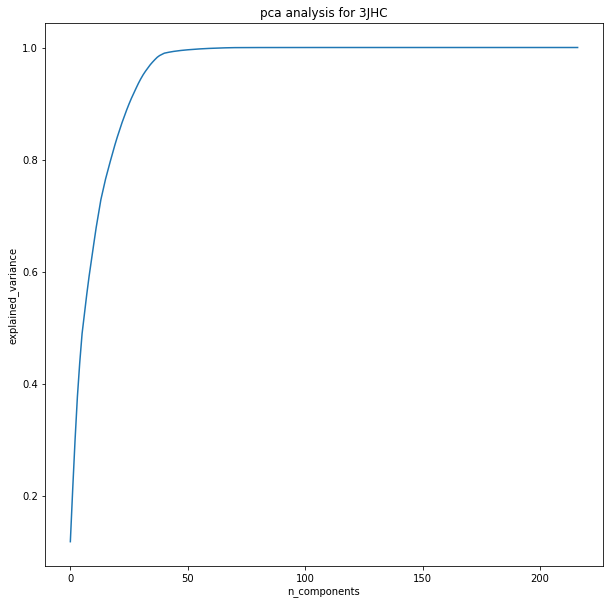

keeping 78 pca components gives more than 0.9999 variance_ratio
fraction of variance explained by the first 78 pca components is: 0.9998978138309363


In [47]:
tp='3JHC'
scaler, pca, X_train, y_train, X_val, y_val, n_features=feature_processing(tp)

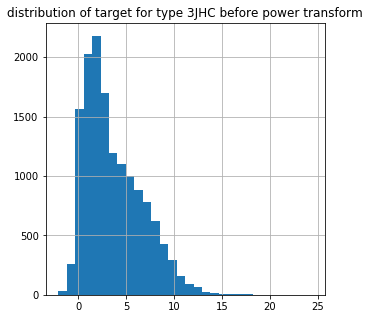

<Figure size 432x288 with 0 Axes>

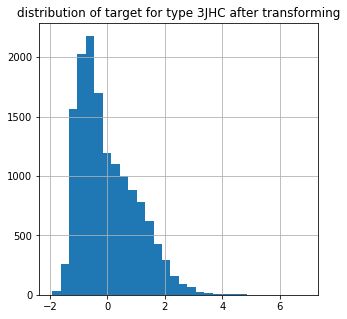

In [48]:
target_pipe=transform_target(tp)

In [49]:
y_train_trans=target_pipe.transform(y_train.reshape(-1,1)).reshape(-1,)
y_val_trans=target_pipe.transform(y_val.reshape(-1,1)).reshape(-1,)

In [50]:
print(X_train.shape)
print(X_val.shape)
print(y_train_trans.shape)
print(y_val_trans.shape)

(14415, 78)
(3384, 78)
(14415,)
(3384,)


In [51]:
models=model_ensembles(tp, n_features, X_train, y_train_trans, X_val, y_val_trans, load_saved_weights=True, verbosity=1,
                    epochs=2, batch_size=1000, min_change=0.01,
                    patience=100, choice_of_models=[1, 4, 5])

generating and training model : 1, verbosity is 1
Instructions for updating:
Colocations handled automatically by placer.
loading saved weights
Instructions for updating:
Use tf.cast instead.
Train on 14415 samples, validate on 3384 samples
Epoch 1/2
14415/14415 [==============================] - 16s 1ms/step - loss: 0.1190 - R2_score: 0.9690 - val_loss: 0.4574 - val_R2_score: 0.5765

Epoch 00001: val_loss improved from inf to 0.45743, saving model to SavedModels/v2/CHAMPS_3JHC/DNN_1_weights.best.from_scratch.hdf5
Epoch 2/2
14415/14415 [==============================] - 1s 101us/step - loss: 0.1287 - R2_score: 0.9632 - val_loss: 0.4564 - val_R2_score: 0.5677

Epoch 00002: val_loss improved from 0.45743 to 0.45636, saving model to SavedModels/v2/CHAMPS_3JHC/DNN_1_weights.best.from_scratch.hdf5
Done!!
generating and training model : 4, verbosity is 1
loading saved weights
Train on 14415 samples, validate on 3384 samples
Epoch 1/2
14415/14415 [==============================] - 15s 1ms/ste

In [52]:
len(models)

3

training set predictions for 1-th model; the mae is: 0.33504053538819534, r2_score is: 0.9717210255016067


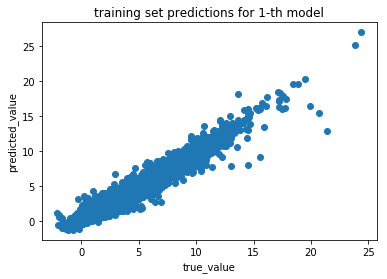

validation set predictions for 1-th model; the mae is: 1.369660769783983, r2_score is: 0.5640509388506535


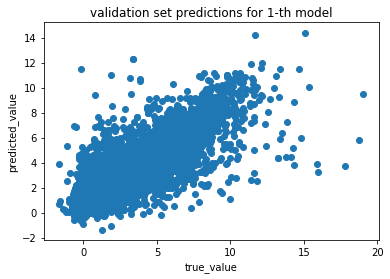

training set predictions for 2-th model; the mae is: 0.3253007073885397, r2_score is: 0.9731290633306323


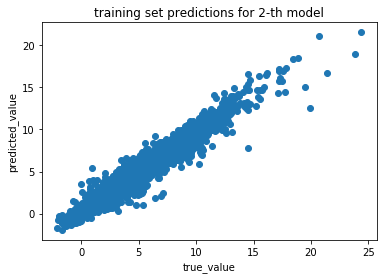

validation set predictions for 2-th model; the mae is: 1.3518963881301265, r2_score is: 0.5613318676124519


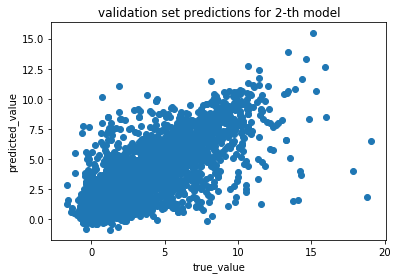

training set predictions for 3-th model; the mae is: 0.27771790174054684, r2_score is: 0.9807982966610138


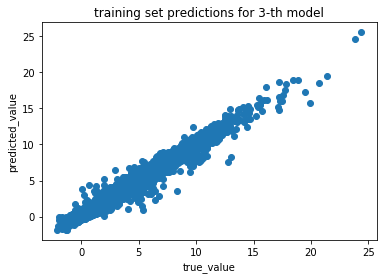

validation set predictions for 3-th model; the mae is: 1.3650928312717718, r2_score is: 0.572368788253015


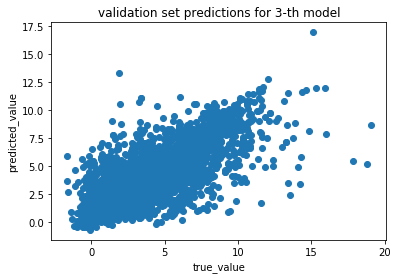

Averaged training set predictions; the mae is: 0.20947850053165812, r2_score is: 0.9885620496489574


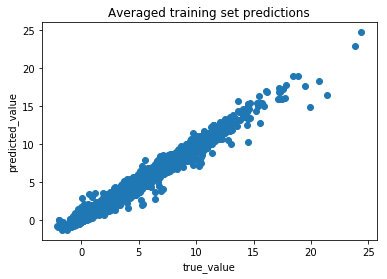

Averaged validation set predictions; the mae is: 1.2700956784841269, r2_score is: 0.6222862816203647


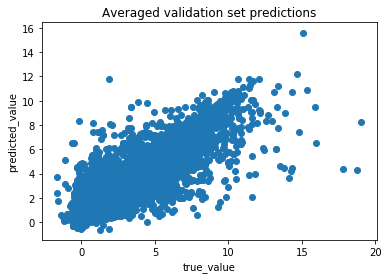

In [53]:
validation_results(X_train, y_train, X_val, y_val, models, target_pipe)

#### Predictions on the CHAMPS test set

In [54]:
# preparing test set features
test_sub, X_test=test_features(tp, scaler, pca)

Great! dat_0 for type 3JHC contains no missing entries
Great! dat_1 for type 3JHC contains no missing entries
Great! There are no Nans or infs in X_test
shape of test set feature array: (10740, 217)
shape of test set feature array after pca reduction: (10740, 78)


In [55]:
# test set predictions
y_pred=test_predictions(tp, X_test, X_val, y_val, target_pipe,  choice_of_models=[1,4,5])
test_sub['scalar_coupling_constant']=y_pred
test_sub.head()

generating and loading model : 1
loading saved weights
Done!!
generating and loading model : 4
loading saved weights
Done!!
generating and loading model : 5
loading saved weights
Done!!


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667400,dsgdb9nsd_000658,6,2,3JHC,5.787985
1,4667401,dsgdb9nsd_000658,6,4,3JHC,5.789751
2,4667410,dsgdb9nsd_000658,7,2,3JHC,2.387945
3,4667411,dsgdb9nsd_000658,7,4,3JHC,2.385702
4,4667420,dsgdb9nsd_000658,8,3,3JHC,5.787856


In [56]:
# storing the results into a file
pred_file_path=os.path.join(current_dir, 'predictions_v2', '{}_predictions.csv'.format(tp))
test_sub.to_csv(pred_file_path, index=False)

In [57]:
# checking that the file was stored properly
pred_check=pd.read_csv(pred_file_path)
pred_check.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667400,dsgdb9nsd_000658,6,2,3JHC,5.787985
1,4667401,dsgdb9nsd_000658,6,4,3JHC,5.789751
2,4667410,dsgdb9nsd_000658,7,2,3JHC,2.387945
3,4667411,dsgdb9nsd_000658,7,4,3JHC,2.385702
4,4667420,dsgdb9nsd_000658,8,3,3JHC,5.787856


## type: 3JHN

Great! dat_0 for type 3JHN contains no missing entries
Great! dat_1 for type 3JHN contains no missing entries
Great! There are no Nans or infs in X_train
Great! There are no Nans or infs in X_val
shape of training set feature array: (1565, 203)
shape of validation set feature array: (384, 203)
shape of training set target array: (1565,)
shape of validation set target array: (384,)


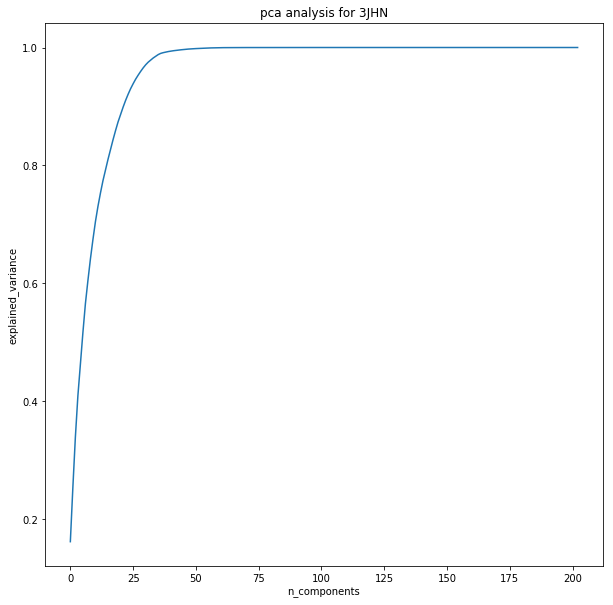

keeping 68 pca components gives more than 0.9999 variance_ratio
fraction of variance explained by the first 78 pca components is: 0.9999696432344519


In [58]:
tp='3JHN'
scaler, pca, X_train, y_train, X_val, y_val, n_features=feature_processing(tp)

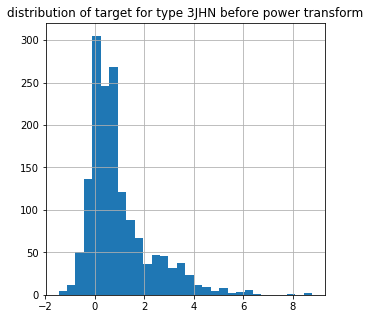

<Figure size 432x288 with 0 Axes>

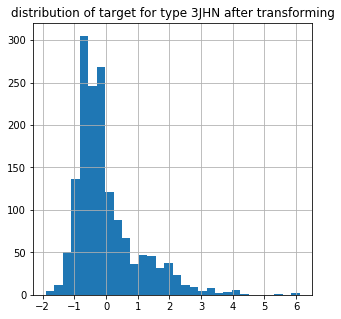

In [59]:
target_pipe=transform_target(tp)

In [60]:
y_train_trans=target_pipe.transform(y_train.reshape(-1,1)).reshape(-1,)
y_val_trans=target_pipe.transform(y_val.reshape(-1,1)).reshape(-1,)

In [61]:
print(X_train.shape)
print(X_val.shape)
print(y_train_trans.shape)
print(y_val_trans.shape)

(1565, 78)
(384, 78)
(1565,)
(384,)


In [62]:
models=model_ensembles(tp, n_features, X_train, y_train_trans, X_val, y_val_trans, load_saved_weights=True, verbosity=1,
                    epochs=2, batch_size=1000, min_change=0.02,
                    patience=200, choice_of_models=[1,4,6])

generating and training model : 1, verbosity is 1
loading saved weights
Train on 1565 samples, validate on 384 samples
Epoch 1/2
1565/1565 [==============================] - 13s 9ms/step - loss: 0.1006 - R2_score: 0.9541 - val_loss: 0.4652 - val_R2_score: 0.4909

Epoch 00001: val_loss improved from inf to 0.46525, saving model to SavedModels/v2/CHAMPS_3JHN/DNN_1_weights.best.from_scratch.hdf5
Epoch 2/2
1565/1565 [==============================] - 0s 92us/step - loss: 0.1095 - R2_score: 0.9553 - val_loss: 0.4831 - val_R2_score: 0.4748

Epoch 00002: val_loss did not improve from 0.46525
Done!!
generating and training model : 4, verbosity is 1
loading saved weights
Train on 1565 samples, validate on 384 samples
Epoch 1/2
1565/1565 [==============================] - 9s 6ms/step - loss: 0.1040 - R2_score: 0.9459 - val_loss: 0.4672 - val_R2_score: 0.4871

Epoch 00001: val_loss improved from inf to 0.46721, saving model to SavedModels/v2/CHAMPS_3JHN/DNN_4_weights.best.from_scratch.hdf5
Epoch 

In [63]:
len(models)

3

training set predictions for 1-th model; the mae is: 0.14136729691671215, r2_score is: 0.9576219815681303


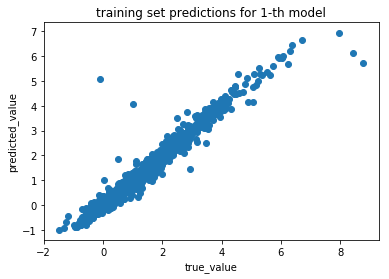

validation set predictions for 1-th model; the mae is: 0.5955424213677839, r2_score is: 0.4908598025218137


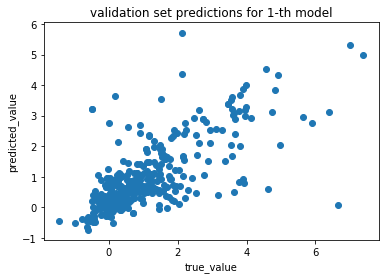

training set predictions for 2-th model; the mae is: 0.1140875493307542, r2_score is: 0.9547545745891722


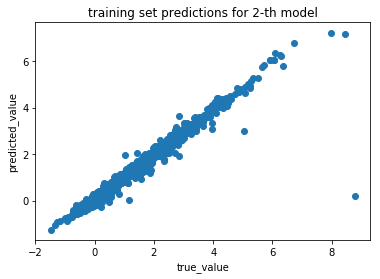

validation set predictions for 2-th model; the mae is: 0.5817214624572337, r2_score is: 0.5071527552863819


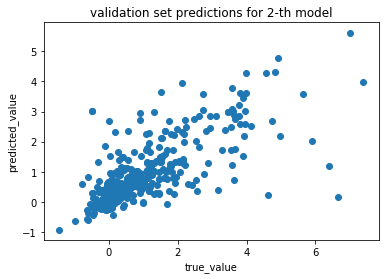

training set predictions for 3-th model; the mae is: 0.06500832614195368, r2_score is: 0.9771087426164179


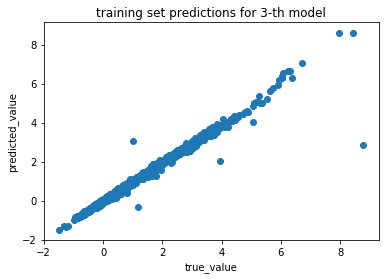

validation set predictions for 3-th model; the mae is: 0.5687852784181128, r2_score is: 0.49198406122264693


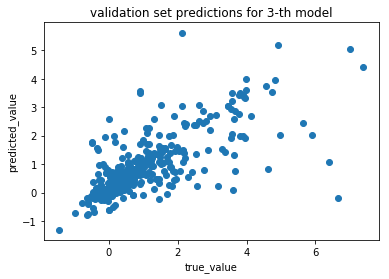

Averaged training set predictions; the mae is: 0.07486143711373552, r2_score is: 0.976312797865766


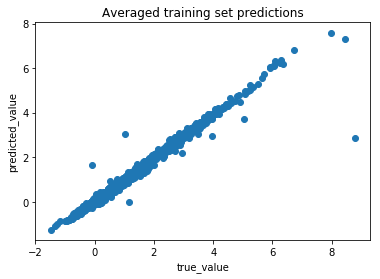

Averaged validation set predictions; the mae is: 0.5520785085088818, r2_score is: 0.534950217082889


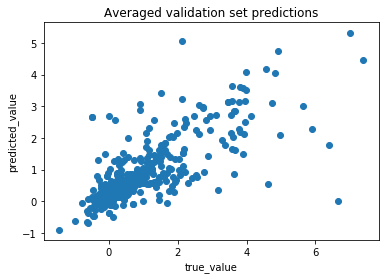

In [64]:
validation_results(X_train, y_train, X_val, y_val, models, target_pipe)

#### Predictions on the CHAMPS test set

In [65]:
# preparing test set features
test_sub, X_test=test_features(tp, scaler, pca)

Great! dat_0 for type 3JHN contains no missing entries
Great! dat_1 for type 3JHN contains no missing entries
Great! There are no Nans or infs in X_test
shape of test set feature array: (1184, 203)
shape of test set feature array after pca reduction: (1184, 78)


In [66]:
# test set predictions
y_pred=test_predictions(tp, X_test, X_val, y_val, target_pipe,  choice_of_models=[1,4,6])
test_sub['scalar_coupling_constant']=y_pred
test_sub.head()

generating and loading model : 1
loading saved weights
Done!!
generating and loading model : 4
loading saved weights
Done!!
generating and loading model : 6
loading saved weights
Done!!


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4684274,dsgdb9nsd_001850,7,2,3JHN,1.565246
1,4684279,dsgdb9nsd_001850,8,2,3JHN,0.937821
2,4684283,dsgdb9nsd_001850,9,2,3JHN,1.565118
3,4691600,dsgdb9nsd_002308,14,6,3JHN,0.854370
4,4691607,dsgdb9nsd_002308,15,6,3JHN,0.900811


In [67]:
# storing the results into a file
pred_file_path=os.path.join(current_dir, 'predictions_v2', '{}_predictions.csv'.format(tp))
test_sub.to_csv(pred_file_path, index=False)

In [68]:
# checking that the file was stored properly
pred_check=pd.read_csv(pred_file_path)
pred_check.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4684274,dsgdb9nsd_001850,7,2,3JHN,1.565246
1,4684279,dsgdb9nsd_001850,8,2,3JHN,0.937821
2,4684283,dsgdb9nsd_001850,9,2,3JHN,1.565118
3,4691600,dsgdb9nsd_002308,14,6,3JHN,0.854370
4,4691607,dsgdb9nsd_002308,15,6,3JHN,0.900811


## type: 3JHH

Great! dat_0 for type 3JHH contains no missing entries
Great! dat_1 for type 3JHH contains no missing entries
Great! There are no Nans or infs in X_train
Great! There are no Nans or infs in X_val
shape of training set feature array: (5559, 217)
shape of validation set feature array: (1447, 217)
shape of training set target array: (5559,)
shape of validation set target array: (1447,)


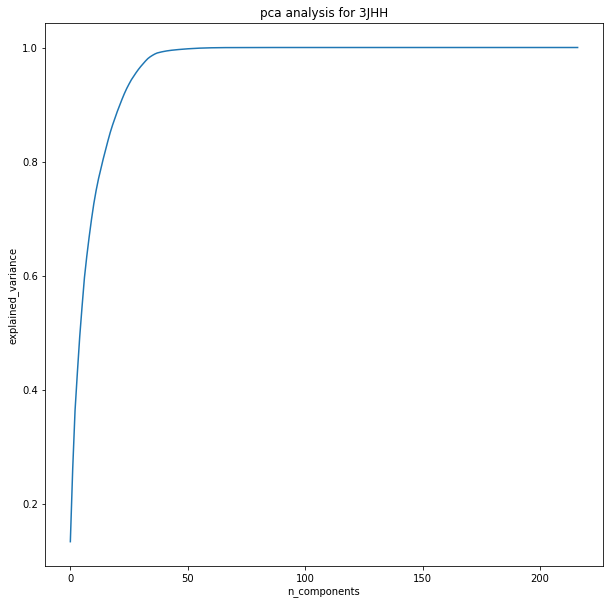

keeping 73 pca components gives more than 0.9999 variance_ratio
fraction of variance explained by the first 76 pca components is: 0.9999267868236694


In [69]:
tp='3JHH'
scaler, pca, X_train, y_train, X_val, y_val, n_features=feature_processing(tp)

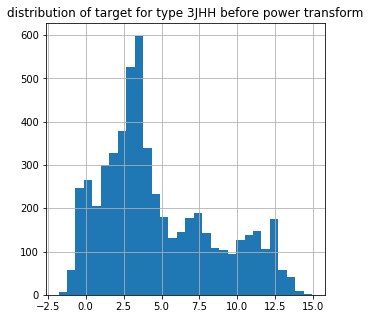

<Figure size 432x288 with 0 Axes>

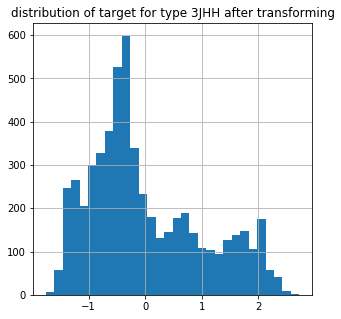

In [70]:
target_pipe=transform_target(tp)

In [71]:
y_train_trans=target_pipe.transform(y_train.reshape(-1,1)).reshape(-1,)
y_val_trans=target_pipe.transform(y_val.reshape(-1,1)).reshape(-1,)

In [72]:
print(X_train.shape)
print(X_val.shape)
print(y_train_trans.shape)
print(y_val_trans.shape)

(5559, 76)
(1447, 76)
(5559,)
(1447,)


In [73]:
models=model_ensembles(tp, n_features, X_train, y_train_trans, X_val, y_val_trans, load_saved_weights=True, verbosity=1,
                    epochs=2, batch_size=1000, min_change=0.02,
                    patience=200, choice_of_models=[2,4,6])

generating and training model : 2, verbosity is 1
loading saved weights
Train on 5559 samples, validate on 1447 samples
Epoch 1/2
5559/5559 [==============================] - 6s 1ms/step - loss: 0.1470 - R2_score: 0.9522 - val_loss: 0.2358 - val_R2_score: 0.8587

Epoch 00001: val_loss improved from inf to 0.23585, saving model to SavedModels/v2/CHAMPS_3JHH/DNN_2_weights.best.from_scratch.hdf5
Epoch 2/2
5559/5559 [==============================] - 0s 73us/step - loss: 0.1412 - R2_score: 0.9547 - val_loss: 0.2398 - val_R2_score: 0.8506

Epoch 00002: val_loss did not improve from 0.23585
Done!!
generating and training model : 4, verbosity is 1
loading saved weights
Train on 5559 samples, validate on 1447 samples
Epoch 1/2
5559/5559 [==============================] - 9s 2ms/step - loss: 0.1450 - R2_score: 0.9526 - val_loss: 0.2915 - val_R2_score: 0.0912

Epoch 00001: val_loss improved from inf to 0.29152, saving model to SavedModels/v2/CHAMPS_3JHH/DNN_4_weights.best.from_scratch.hdf5
Epoch

In [74]:
len(models)

3

training set predictions for 1-th model; the mae is: 0.48994905232862435, r2_score is: 0.9598536086569303


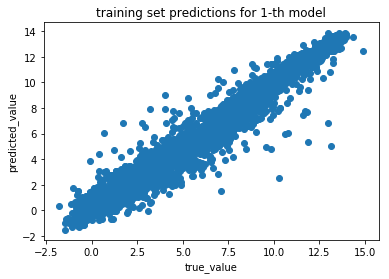

validation set predictions for 1-th model; the mae is: 0.8788441724856084, r2_score is: 0.8629111591601344


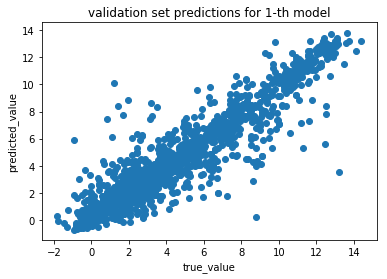

training set predictions for 2-th model; the mae is: 0.4602035241589557, r2_score is: 0.965061285325876


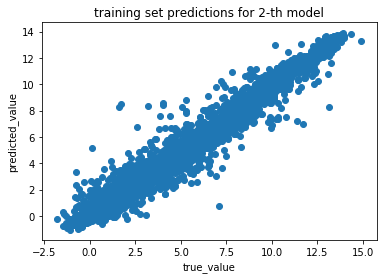

validation set predictions for 2-th model; the mae is: 1.0143529434026286, r2_score is: -0.44468589162726024


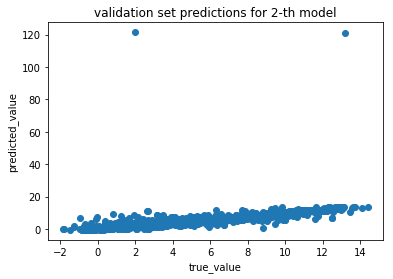

training set predictions for 3-th model; the mae is: 0.4158140572710718, r2_score is: 0.9711288070814357


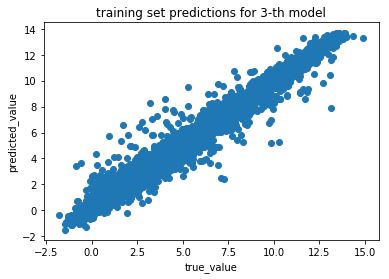

validation set predictions for 3-th model; the mae is: 0.950540421005264, r2_score is: 0.7694545825363511


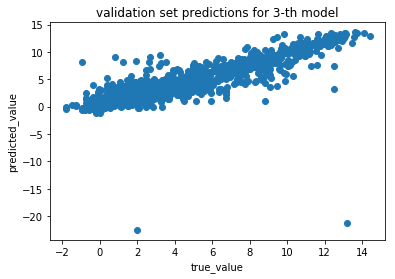

Averaged training set predictions; the mae is: 0.47231281279511056, r2_score is: 0.9635215969516622


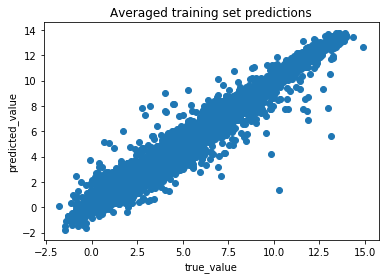

Averaged validation set predictions; the mae is: 0.9988644684759762, r2_score is: 0.4337551103024425


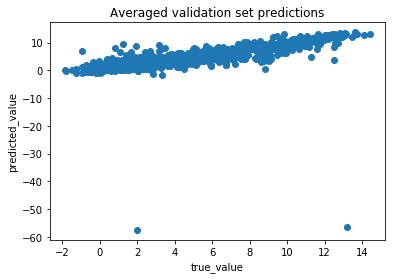

In [75]:
validation_results(X_train, y_train, X_val, y_val, models, target_pipe)

#### Predictions on the CHAMPS test set

In [76]:
# preparing test set features
test_sub, X_test=test_features(tp, scaler, pca)

Great! dat_0 for type 3JHH contains no missing entries
Great! dat_1 for type 3JHH contains no missing entries
Great! There are no Nans or infs in X_test
shape of test set feature array: (4141, 217)
shape of test set feature array after pca reduction: (4141, 76)


In [77]:
# test set predictions
y_pred=test_predictions(tp, X_test, X_val, y_val, target_pipe,  choice_of_models=[2,4,6])
test_sub['scalar_coupling_constant']=y_pred
test_sub.head()

generating and loading model : 2
loading saved weights
Done!!
generating and loading model : 4
loading saved weights
Done!!
generating and loading model : 6
loading saved weights
Done!!


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667404,dsgdb9nsd_000658,6,8,3JHH,1.775538
1,4667405,dsgdb9nsd_000658,6,9,3JHH,2.934270
2,4667406,dsgdb9nsd_000658,6,16,3JHH,2.924609
3,4667407,dsgdb9nsd_000658,6,17,3JHH,1.755000
4,4667413,dsgdb9nsd_000658,7,8,3JHH,3.132375


In [78]:
# storing the results into a file
pred_file_path=os.path.join(current_dir, 'predictions_v2', '{}_predictions.csv'.format(tp))
test_sub.to_csv(pred_file_path, index=False)

In [79]:
# checking that the file was stored properly
pred_check=pd.read_csv(pred_file_path)
pred_check.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667404,dsgdb9nsd_000658,6,8,3JHH,1.775538
1,4667405,dsgdb9nsd_000658,6,9,3JHH,2.934270
2,4667406,dsgdb9nsd_000658,6,16,3JHH,2.924609
3,4667407,dsgdb9nsd_000658,6,17,3JHH,1.755000
4,4667413,dsgdb9nsd_000658,7,8,3JHH,3.132375


## type: 2JHC

Great! dat_0 for type 2JHC contains no missing entries
Great! dat_1 for type 2JHC contains no missing entries
Great! There are no Nans or infs in X_train
Great! There are no Nans or infs in X_val
shape of training set feature array: (10771, 217)
shape of validation set feature array: (2678, 217)
shape of training set target array: (10771,)
shape of validation set target array: (2678,)


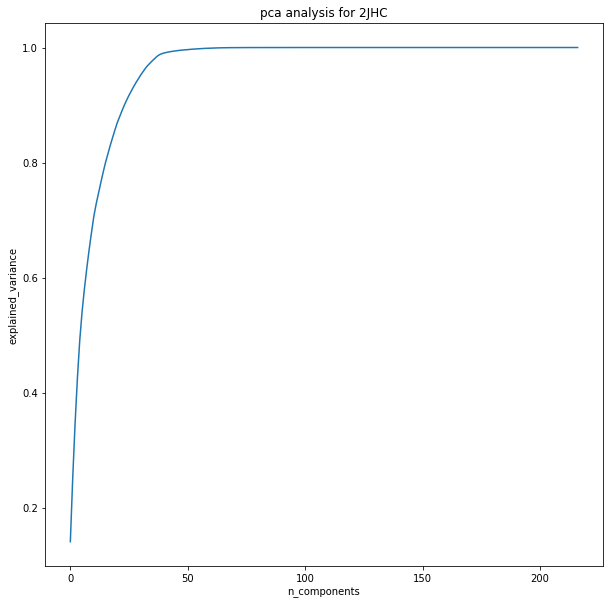

keeping 77 pca components gives more than 0.9999 variance_ratio
fraction of variance explained by the first 77 pca components is: 0.9998999977772294


In [80]:
tp='2JHC'
scaler, pca, X_train, y_train, X_val, y_val, n_features=feature_processing(tp)

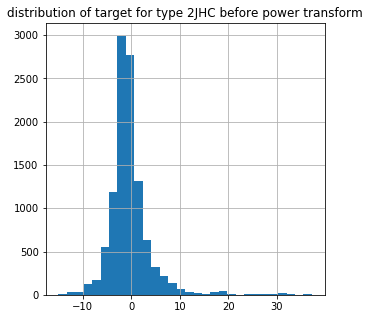

<Figure size 432x288 with 0 Axes>

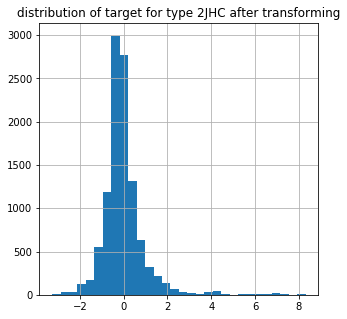

In [81]:
target_pipe=transform_target(tp)

In [82]:
y_train_trans=target_pipe.transform(y_train.reshape(-1,1)).reshape(-1,)
y_val_trans=target_pipe.transform(y_val.reshape(-1,1)).reshape(-1,)

In [83]:
print(X_train.shape)
print(X_val.shape)
print(y_train_trans.shape)
print(y_val_trans.shape)

(10771, 77)
(2678, 77)
(10771,)
(2678,)


In [84]:
models=model_ensembles(tp, n_features, X_train, y_train_trans, X_val, y_val_trans, load_saved_weights=True, verbosity=1,
                    epochs=2, batch_size=1000, min_change=0.01,
                    patience=100, choice_of_models=[4, 5, 6])

generating and training model : 4, verbosity is 1
loading saved weights
Train on 10771 samples, validate on 2678 samples
Epoch 1/2
10771/10771 [==============================] - 9s 832us/step - loss: 0.1387 - R2_score: 0.9564 - val_loss: 0.2866 - val_R2_score: 0.8305

Epoch 00001: val_loss improved from inf to 0.28655, saving model to SavedModels/v2/CHAMPS_2JHC/DNN_4_weights.best.from_scratch.hdf5
Epoch 2/2
10771/10771 [==============================] - 1s 118us/step - loss: 0.1383 - R2_score: 0.9569 - val_loss: 0.2817 - val_R2_score: 0.8296

Epoch 00002: val_loss improved from 0.28655 to 0.28169, saving model to SavedModels/v2/CHAMPS_2JHC/DNN_4_weights.best.from_scratch.hdf5
Done!!
generating and training model : 5, verbosity is 1
loading saved weights
Train on 10771 samples, validate on 2678 samples
Epoch 1/2
10771/10771 [==============================] - 8s 775us/step - loss: 0.1421 - R2_score: 0.9488 - val_loss: 0.2880 - val_R2_score: 0.8201

Epoch 00001: val_loss improved from inf

In [85]:
len(models)

3

training set predictions for 1-th model; the mae is: 0.5286057928573218, r2_score is: 0.9679156958035392


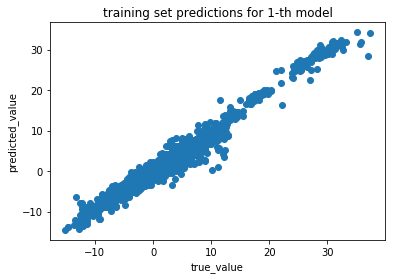

validation set predictions for 1-th model; the mae is: 1.273162346803631, r2_score is: 0.83691150533395


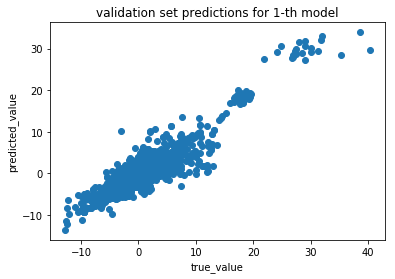

training set predictions for 2-th model; the mae is: 0.5240255448129228, r2_score is: 0.9648001630573143


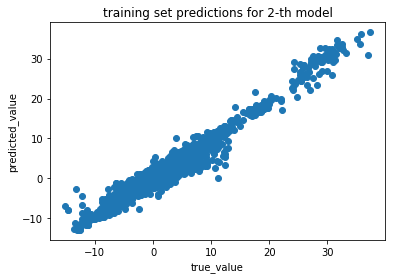

validation set predictions for 2-th model; the mae is: 1.2525711796862757, r2_score is: 0.8360616306656747


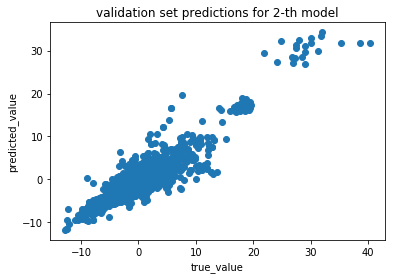

training set predictions for 3-th model; the mae is: 0.5122106066874459, r2_score is: 0.9675189514022647


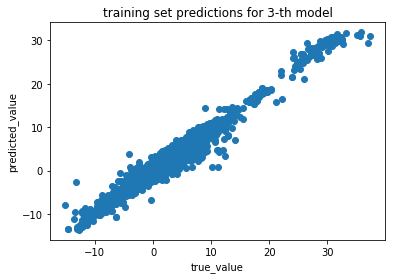

validation set predictions for 3-th model; the mae is: 1.2248209230263716, r2_score is: 0.8452870476538669


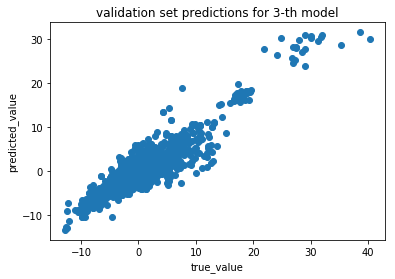

Averaged training set predictions; the mae is: 0.39153851044067906, r2_score is: 0.97939553209575


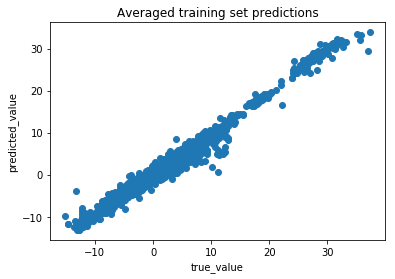

Averaged validation set predictions; the mae is: 1.1505569191980247, r2_score is: 0.860418090376975


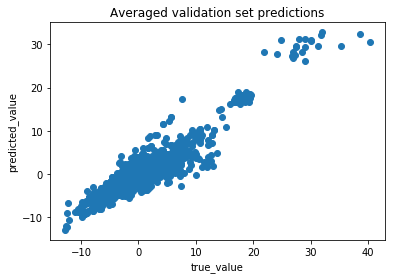

In [86]:
validation_results(X_train, y_train, X_val, y_val, models, target_pipe)

#### Predictions on the CHAMPS test set

In [87]:
# preparing test set features
test_sub, X_test=test_features(tp, scaler, pca)

Great! dat_0 for type 2JHC contains no missing entries
Great! dat_1 for type 2JHC contains no missing entries
Great! There are no Nans or infs in X_test
shape of test set feature array: (8012, 217)
shape of test set feature array after pca reduction: (8012, 77)


In [88]:
# test set predictions
y_pred=test_predictions(tp, X_test, X_val, y_val, target_pipe,  choice_of_models=[4,5,6])
test_sub['scalar_coupling_constant']=y_pred
test_sub.head()

generating and loading model : 4
loading saved weights
Done!!
generating and loading model : 5
loading saved weights
Done!!
generating and loading model : 6
loading saved weights
Done!!


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667399,dsgdb9nsd_000658,6,1,2JHC,-1.479047
1,4667402,dsgdb9nsd_000658,6,5,2JHC,-1.477652
2,4667409,dsgdb9nsd_000658,7,1,2JHC,-1.497120
3,4667412,dsgdb9nsd_000658,7,5,2JHC,-1.498134
4,4667417,dsgdb9nsd_000658,8,0,2JHC,-1.479152


In [89]:
# storing the results into a file
pred_file_path=os.path.join(current_dir, 'predictions_v2', '{}_predictions.csv'.format(tp))
test_sub.to_csv(pred_file_path, index=False)

In [90]:
# checking that the file was stored properly
pred_check=pd.read_csv(pred_file_path)
pred_check.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667399,dsgdb9nsd_000658,6,1,2JHC,-1.479047
1,4667402,dsgdb9nsd_000658,6,5,2JHC,-1.477652
2,4667409,dsgdb9nsd_000658,7,1,2JHC,-1.497120
3,4667412,dsgdb9nsd_000658,7,5,2JHC,-1.498134
4,4667417,dsgdb9nsd_000658,8,0,2JHC,-1.479152


## type: 2JHN

Great! dat_0 for type 2JHN contains no missing entries
Great! dat_1 for type 2JHN contains no missing entries
Great! There are no Nans or infs in X_train
Great! There are no Nans or infs in X_val
shape of training set feature array: (1130, 217)
shape of validation set feature array: (264, 217)
shape of training set target array: (1130,)
shape of validation set target array: (264,)


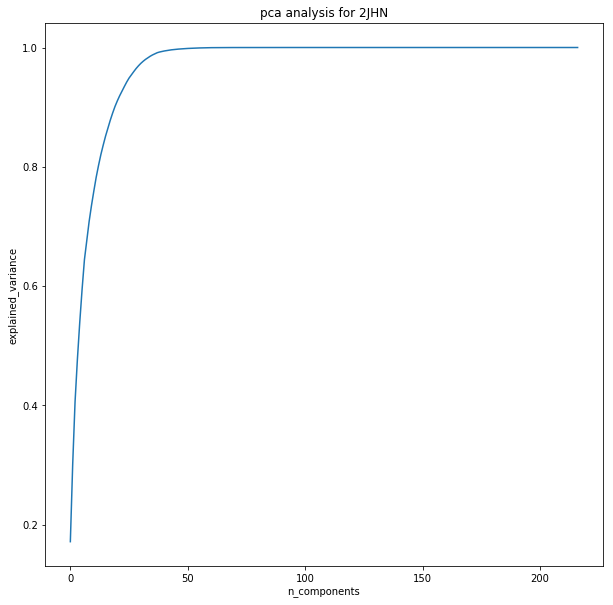

keeping 67 pca components gives more than 0.9999 variance_ratio
fraction of variance explained by the first 75 pca components is: 0.9999672038039603


In [91]:
tp='2JHN'
scaler, pca, X_train, y_train, X_val, y_val, n_features=feature_processing(tp)

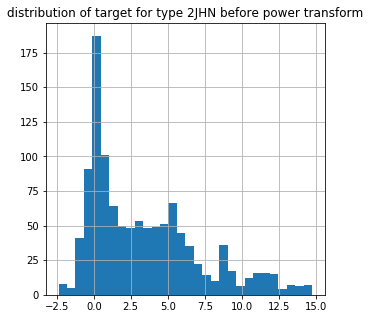

<Figure size 432x288 with 0 Axes>

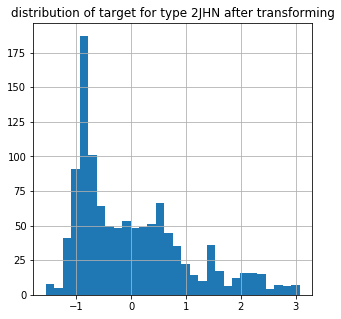

In [92]:
target_pipe=transform_target(tp)

In [93]:
y_train_trans=target_pipe.transform(y_train.reshape(-1,1)).reshape(-1,)
y_val_trans=target_pipe.transform(y_val.reshape(-1,1)).reshape(-1,)

In [94]:
print(X_train.shape)
print(X_val.shape)
print(y_train_trans.shape)
print(y_val_trans.shape)

(1130, 75)
(264, 75)
(1130,)
(264,)


In [95]:
# In the implementation for google colab, we included model 7 in choice_of_models here
# but it is too big for my laptop's GPU which subsequently stops and flashes OOM error
# so we will remove model 7 for the purposes of sample calculations here
models=model_ensembles(tp, n_features, X_train, y_train_trans, X_val, y_val_trans, load_saved_weights=True, verbosity=1,
                    epochs=2, batch_size=1000, min_change=0.02,
                    patience=200, choice_of_models=[1,2])

generating and training model : 1, verbosity is 1
loading saved weights
Train on 1130 samples, validate on 264 samples
Epoch 1/2
1130/1130 [==============================] - 17s 15ms/step - loss: 0.1912 - R2_score: 0.9171 - val_loss: 0.2656 - val_R2_score: 0.8406

Epoch 00001: val_loss improved from inf to 0.26562, saving model to SavedModels/v2/CHAMPS_2JHN/DNN_1_weights.best.from_scratch.hdf5
Epoch 2/2
1130/1130 [==============================] - 0s 142us/step - loss: 0.1907 - R2_score: 0.9281 - val_loss: 0.2126 - val_R2_score: 0.8963

Epoch 00002: val_loss improved from 0.26562 to 0.21257, saving model to SavedModels/v2/CHAMPS_2JHN/DNN_1_weights.best.from_scratch.hdf5
Done!!
generating and training model : 2, verbosity is 1
loading saved weights
Train on 1130 samples, validate on 264 samples
Epoch 1/2
1130/1130 [==============================] - 7s 6ms/step - loss: 0.1595 - R2_score: 0.9493 - val_loss: 0.2613 - val_R2_score: 0.8532

Epoch 00001: val_loss improved from inf to 0.26132,

In [96]:
len(models)

2

training set predictions for 1-th model; the mae is: 0.6777023596439696, r2_score is: 0.9258517017347353


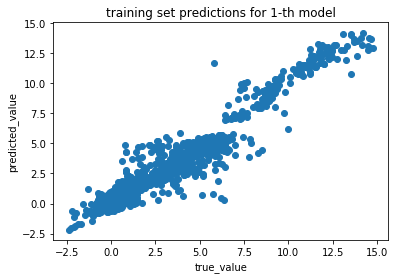

validation set predictions for 1-th model; the mae is: 0.7881918116926676, r2_score is: 0.8962919424133168


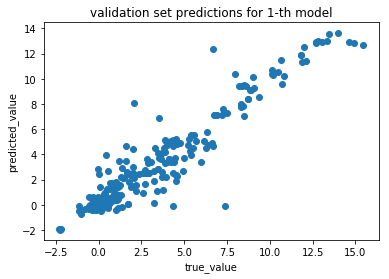

training set predictions for 2-th model; the mae is: 0.5989373075478513, r2_score is: 0.9422485508176887


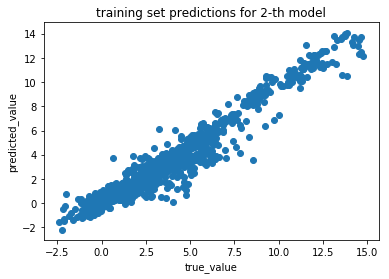

validation set predictions for 2-th model; the mae is: 0.8436786974825166, r2_score is: 0.8891152171890059


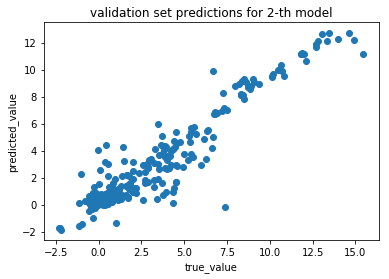

Averaged training set predictions; the mae is: 0.5668711302118201, r2_score is: 0.9478127168177897


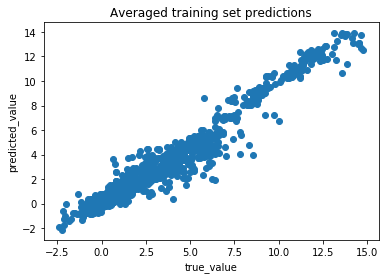

Averaged validation set predictions; the mae is: 0.7488497269306352, r2_score is: 0.9082721286180166


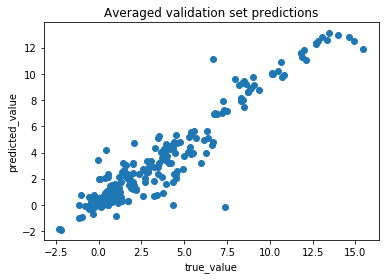

In [97]:
validation_results(X_train, y_train, X_val, y_val, models, target_pipe)

#### Predictions on the CHAMPS test set

In [98]:
# preparing test set features
test_sub, X_test=test_features(tp, scaler, pca)

Great! dat_0 for type 2JHN contains no missing entries
Great! dat_1 for type 2JHN contains no missing entries
Great! There are no Nans or infs in X_test
shape of test set feature array: (906, 217)
shape of test set feature array after pca reduction: (906, 75)


In [99]:
# test set predictions
y_pred=test_predictions(tp, X_test, X_val, y_val, target_pipe,  choice_of_models=[1,2])
test_sub['scalar_coupling_constant']=y_pred
test_sub.head()

generating and loading model : 1
loading saved weights
Done!!
generating and loading model : 2
loading saved weights
Done!!


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4679122,dsgdb9nsd_001527,13,5,2JHN,-0.236930
1,4679127,dsgdb9nsd_001527,14,5,2JHN,0.630448
2,4679131,dsgdb9nsd_001527,15,5,2JHN,0.629352
3,4684285,dsgdb9nsd_001850,10,2,2JHN,0.849527
4,4684290,dsgdb9nsd_001850,11,2,2JHN,0.849205


In [100]:
# storing the results into a file
pred_file_path=os.path.join(current_dir, 'predictions_v2', '{}_predictions.csv'.format(tp))
test_sub.to_csv(pred_file_path, index=False)

In [101]:
# checking that the file was stored properly
pred_check=pd.read_csv(pred_file_path)
pred_check.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4679122,dsgdb9nsd_001527,13,5,2JHN,-0.236930
1,4679127,dsgdb9nsd_001527,14,5,2JHN,0.630448
2,4679131,dsgdb9nsd_001527,15,5,2JHN,0.629352
3,4684285,dsgdb9nsd_001850,10,2,2JHN,0.849527
4,4684290,dsgdb9nsd_001850,11,2,2JHN,0.849205


## type: 1JHN

Great! dat_0 for type 1JHN contains no missing entries
Great! dat_1 for type 1JHN contains no missing entries
Great! There are no Nans or infs in X_train
Great! There are no Nans or infs in X_val
shape of training set feature array: (404, 217)
shape of validation set feature array: (90, 217)
shape of training set target array: (404,)
shape of validation set target array: (90,)


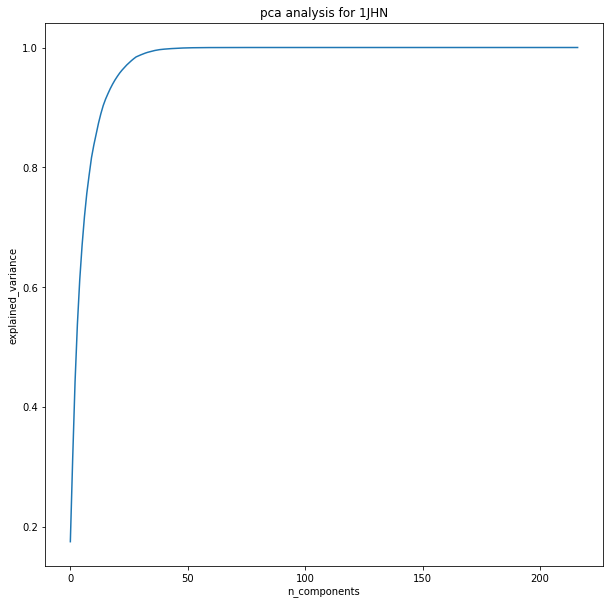

keeping 61 pca components gives more than 0.9999 variance_ratio
fraction of variance explained by the first 75 pca components is: 0.9999886134650519


In [102]:
tp='1JHN'
scaler, pca, X_train, y_train, X_val, y_val, n_features=feature_processing(tp)

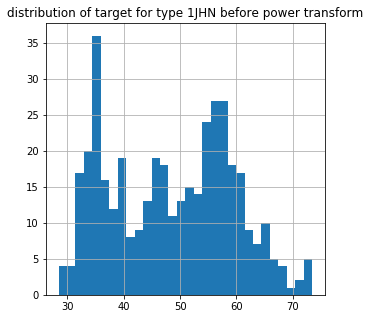

<Figure size 432x288 with 0 Axes>

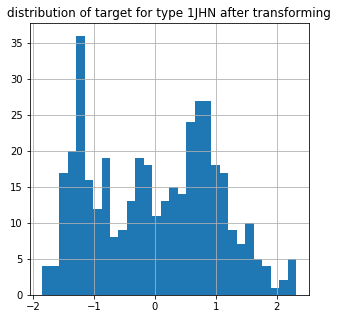

In [103]:
target_pipe=transform_target(tp)

In [104]:
y_train_trans=target_pipe.transform(y_train.reshape(-1,1)).reshape(-1,)
y_val_trans=target_pipe.transform(y_val.reshape(-1,1)).reshape(-1,)

In [105]:
print(X_train.shape)
print(X_val.shape)
print(y_train_trans.shape)
print(y_val_trans.shape)

(404, 75)
(90, 75)
(404,)
(90,)


In [106]:
models=model_ensembles(tp, n_features, X_train, y_train_trans, X_val, y_val_trans, load_saved_weights=True, verbosity=1,
                    epochs=2, batch_size=1000, min_change=0.02,
                    patience=200, choice_of_models=[1,2,3])

generating and training model : 1, verbosity is 1
loading saved weights
Train on 404 samples, validate on 90 samples
Epoch 1/2
404/404 [==============================] - 10s 24ms/step - loss: 0.1966 - R2_score: 0.9311 - val_loss: 0.2530 - val_R2_score: 0.9029

Epoch 00001: val_loss improved from inf to 0.25296, saving model to SavedModels/v2/CHAMPS_1JHN/DNN_1_weights.best.from_scratch.hdf5
Epoch 2/2
404/404 [==============================] - 0s 144us/step - loss: 0.2157 - R2_score: 0.9237 - val_loss: 0.1956 - val_R2_score: 0.9515

Epoch 00002: val_loss improved from 0.25296 to 0.19559, saving model to SavedModels/v2/CHAMPS_1JHN/DNN_1_weights.best.from_scratch.hdf5
Done!!
generating and training model : 2, verbosity is 1
loading saved weights
Train on 404 samples, validate on 90 samples
Epoch 1/2
404/404 [==============================] - 8s 20ms/step - loss: 0.1644 - R2_score: 0.9563 - val_loss: 0.2344 - val_R2_score: 0.9223

Epoch 00001: val_loss improved from inf to 0.23442, saving m

In [107]:
len(models)

3

training set predictions for 1-th model; the mae is: 1.6760939830742263, r2_score is: 0.9597359685698097


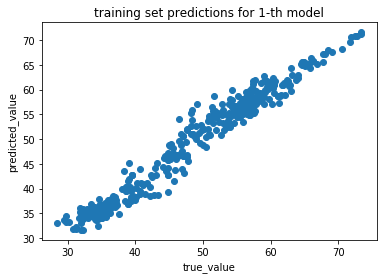

validation set predictions for 1-th model; the mae is: 2.1114678003268774, r2_score is: 0.9515329949542427


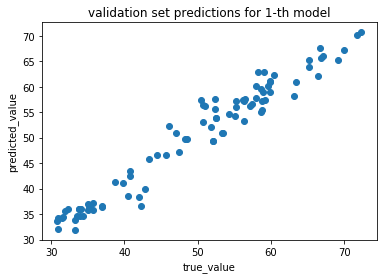

training set predictions for 2-th model; the mae is: 1.9411986127041356, r2_score is: 0.9423193185586037


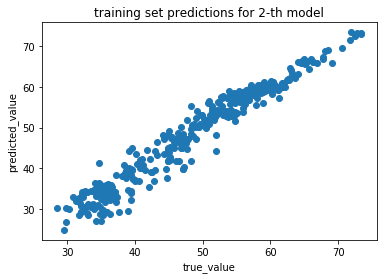

validation set predictions for 2-th model; the mae is: 1.8629253319634334, r2_score is: 0.9560309617247673


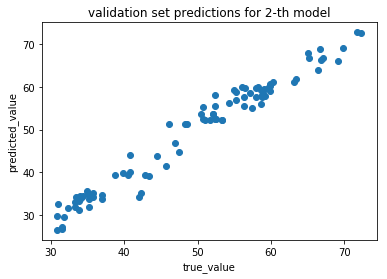

training set predictions for 3-th model; the mae is: 2.006630600383494, r2_score is: 0.9272535939743518


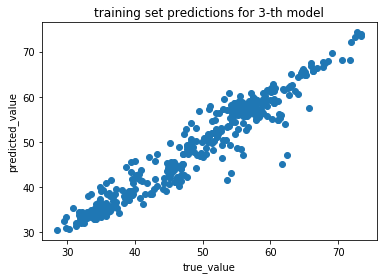

validation set predictions for 3-th model; the mae is: 2.9992291476101345, r2_score is: 0.8277977061378518


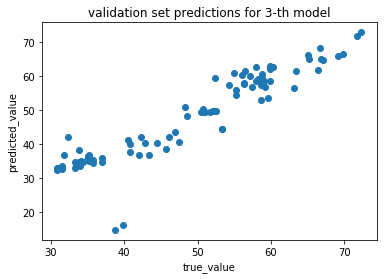

Averaged training set predictions; the mae is: 1.3135984169806783, r2_score is: 0.9757175316142177


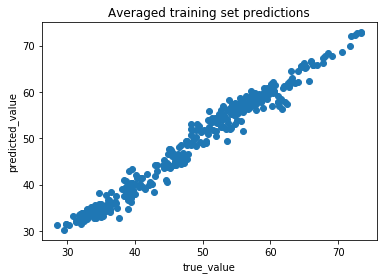

Averaged validation set predictions; the mae is: 1.7316241678680033, r2_score is: 0.9630158215141565


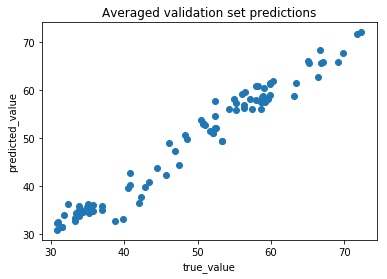

In [108]:
validation_results(X_train, y_train, X_val, y_val, models, target_pipe)

#### Predictions on the CHAMPS test set

In [109]:
# preparing test set features
test_sub, X_test=test_features(tp, scaler, pca)

Great! dat_0 for type 1JHN contains no missing entries
Great! dat_1 for type 1JHN contains no missing entries
Great! There are no Nans or infs in X_test
shape of test set feature array: (294, 217)
shape of test set feature array after pca reduction: (294, 75)


In [110]:
# test set predictions
y_pred=test_predictions(tp, X_test, X_val, y_val, target_pipe,  choice_of_models=[1,2,3])
test_sub['scalar_coupling_constant']=y_pred
test_sub.head()

generating and loading model : 1
loading saved weights
Done!!
generating and loading model : 2
loading saved weights
Done!!
generating and loading model : 3
loading saved weights
Done!!


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4674945,dsgdb9nsd_001263,12,5,1JHN,57.774019
1,4674949,dsgdb9nsd_001263,13,5,1JHN,58.920743
2,4679116,dsgdb9nsd_001527,12,5,1JHN,58.007355
3,4693534,dsgdb9nsd_002424,12,5,1JHN,33.322110
4,4725185,dsgdb9nsd_004873,14,7,1JHN,59.148697


In [111]:
# storing the results into a file
pred_file_path=os.path.join(current_dir, 'predictions_v2', '{}_predictions.csv'.format(tp))
test_sub.to_csv(pred_file_path, index=False)

In [112]:
# checking that the file was stored properly
pred_check=pd.read_csv(pred_file_path)
pred_check.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4674945,dsgdb9nsd_001263,12,5,1JHN,57.774019
1,4674949,dsgdb9nsd_001263,13,5,1JHN,58.920743
2,4679116,dsgdb9nsd_001527,12,5,1JHN,58.007355
3,4693534,dsgdb9nsd_002424,12,5,1JHN,33.322110
4,4725185,dsgdb9nsd_004873,14,7,1JHN,59.148697


## type: 2JHH

Great! dat_0 for type 2JHH contains no missing entries
Great! dat_1 for type 2JHH contains no missing entries
Great! There are no Nans or infs in X_train
Great! There are no Nans or infs in X_val
shape of training set feature array: (3662, 217)
shape of validation set feature array: (830, 217)
shape of training set target array: (3662,)
shape of validation set target array: (830,)


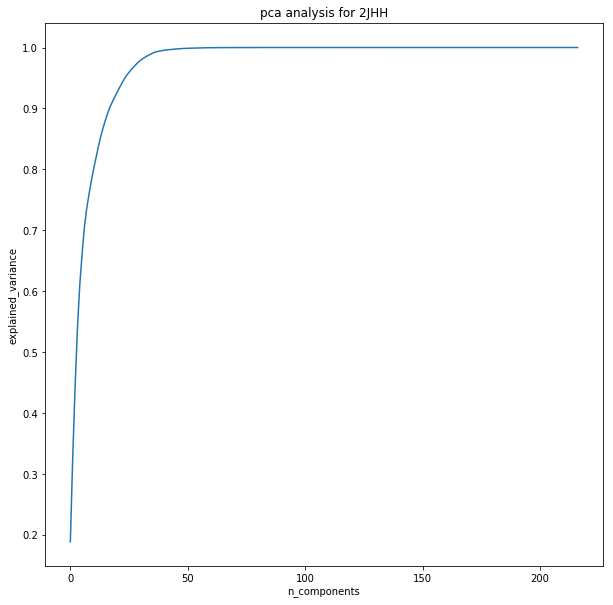

keeping 69 pca components gives more than 0.9999 variance_ratio
fraction of variance explained by the first 76 pca components is: 0.9999561478203624


In [113]:
tp='2JHH'
scaler, pca, X_train, y_train, X_val, y_val, n_features=feature_processing(tp)

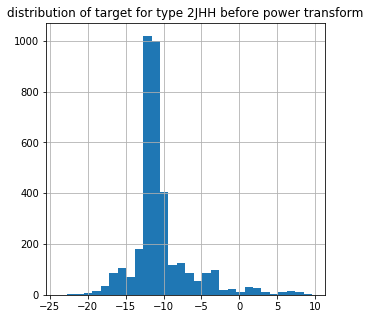

<Figure size 432x288 with 0 Axes>

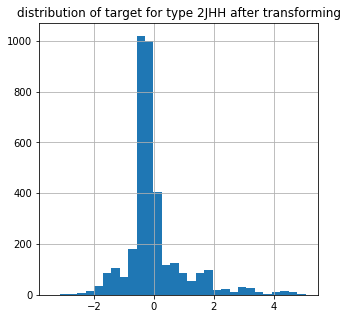

In [114]:
target_pipe=transform_target(tp)

In [115]:
y_train_trans=target_pipe.transform(y_train.reshape(-1,1)).reshape(-1,)
y_val_trans=target_pipe.transform(y_val.reshape(-1,1)).reshape(-1,)

In [116]:
print(X_train.shape)
print(X_val.shape)
print(y_train_trans.shape)
print(y_val_trans.shape)

(3662, 76)
(830, 76)
(3662,)
(830,)


In [117]:
models=model_ensembles(tp, n_features, X_train, y_train_trans, X_val, y_val_trans, load_saved_weights=True, verbosity=1,
                    epochs=2, batch_size=1000, min_change=0.02,
                    patience=200, choice_of_models=[1,2,4])

generating and training model : 1, verbosity is 1
loading saved weights
Train on 3662 samples, validate on 830 samples
Epoch 1/2
3662/3662 [==============================] - 12s 3ms/step - loss: 0.1610 - R2_score: 0.9336 - val_loss: 0.2166 - val_R2_score: 0.8839

Epoch 00001: val_loss improved from inf to 0.21662, saving model to SavedModels/v2/CHAMPS_2JHH/DNN_1_weights.best.from_scratch.hdf5
Epoch 2/2
3662/3662 [==============================] - 0s 88us/step - loss: 0.1514 - R2_score: 0.9425 - val_loss: 0.1918 - val_R2_score: 0.8950

Epoch 00002: val_loss improved from 0.21662 to 0.19184, saving model to SavedModels/v2/CHAMPS_2JHH/DNN_1_weights.best.from_scratch.hdf5
Done!!
generating and training model : 2, verbosity is 1
loading saved weights
Train on 3662 samples, validate on 830 samples
Epoch 1/2
3662/3662 [==============================] - 11s 3ms/step - loss: 0.1549 - R2_score: 0.9440 - val_loss: 0.2024 - val_R2_score: 0.8875

Epoch 00001: val_loss improved from inf to 0.20240, 

In [118]:
len(models)

3

training set predictions for 1-th model; the mae is: 0.49670921680072394, r2_score is: 0.9583571252365388


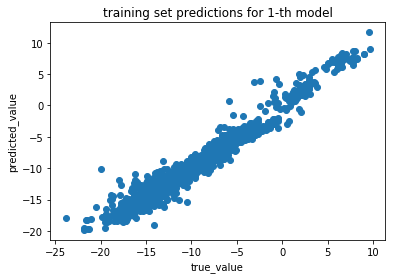

validation set predictions for 1-th model; the mae is: 0.7580713103065065, r2_score is: 0.8949542956774654


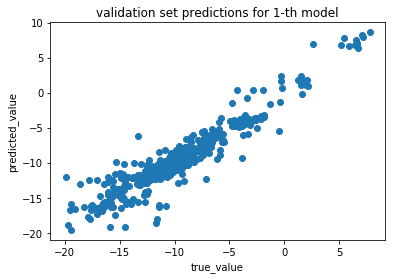

training set predictions for 2-th model; the mae is: 0.5019136754902292, r2_score is: 0.9601851190855877


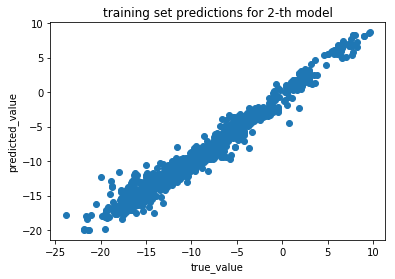

validation set predictions for 2-th model; the mae is: 0.739779823128243, r2_score is: 0.9080519149077668


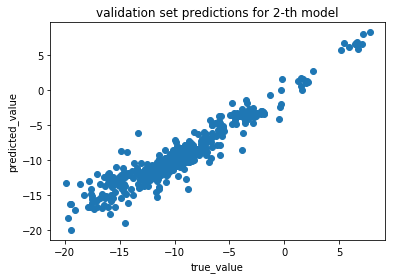

training set predictions for 3-th model; the mae is: 0.5100535822205327, r2_score is: 0.9520568556948125


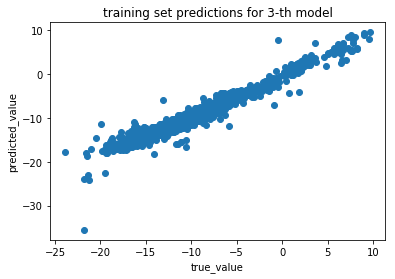

validation set predictions for 3-th model; the mae is: 0.897213095919716, r2_score is: 0.8308671527037608


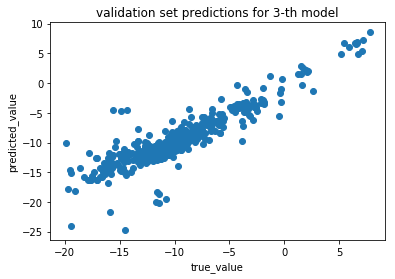

Averaged training set predictions; the mae is: 0.4135901407864901, r2_score is: 0.9704901966232541


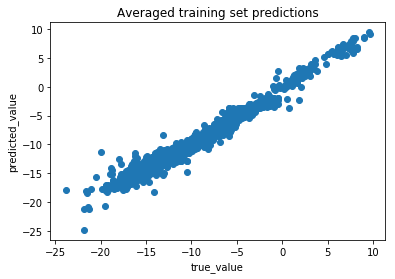

Averaged validation set predictions; the mae is: 0.7137148083285441, r2_score is: 0.9020268217898355


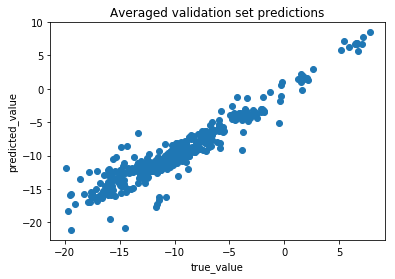

In [119]:
validation_results(X_train, y_train, X_val, y_val, models, target_pipe)

#### Predictions on the CHAMPS test set

In [120]:
# preparing test set features
test_sub, X_test=test_features(tp, scaler, pca)

Great! dat_0 for type 2JHH contains no missing entries
Great! dat_1 for type 2JHH contains no missing entries
Great! There are no Nans or infs in X_test
shape of test set feature array: (2637, 217)
shape of test set feature array after pca reduction: (2637, 76)


In [121]:
# test set predictions
y_pred=test_predictions(tp, X_test, X_val, y_val, target_pipe,  choice_of_models=[1,2,4])
test_sub['scalar_coupling_constant']=y_pred
test_sub.head()

generating and loading model : 1
loading saved weights
Done!!
generating and loading model : 2
loading saved weights
Done!!
generating and loading model : 4
loading saved weights
Done!!


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667403,dsgdb9nsd_000658,6,7,2JHH,-11.746811
1,4667422,dsgdb9nsd_000658,8,9,2JHH,-11.739359
2,4667437,dsgdb9nsd_000658,10,11,2JHH,-11.625396
3,4667452,dsgdb9nsd_000658,12,13,2JHH,-11.746859
4,4667467,dsgdb9nsd_000658,14,15,2JHH,-11.615672


In [122]:
# storing the results into a file
pred_file_path=os.path.join(current_dir, 'predictions_v2', '{}_predictions.csv'.format(tp))
test_sub.to_csv(pred_file_path, index=False)

In [123]:
# checking that the file was stored properly
pred_check=pd.read_csv(pred_file_path)
pred_check.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667403,dsgdb9nsd_000658,6,7,2JHH,-11.746811
1,4667422,dsgdb9nsd_000658,8,9,2JHH,-11.739359
2,4667437,dsgdb9nsd_000658,10,11,2JHH,-11.625396
3,4667452,dsgdb9nsd_000658,12,13,2JHH,-11.746859
4,4667467,dsgdb9nsd_000658,14,15,2JHH,-11.615672


## type: 1JHC

Great! dat_0 for type 1JHC contains no missing entries
Great! dat_1 for type 1JHC contains no missing entries
Great! There are no Nans or infs in X_train
Great! There are no Nans or infs in X_val
shape of training set feature array: (6755, 217)
shape of validation set feature array: (1645, 217)
shape of training set target array: (6755,)
shape of validation set target array: (1645,)


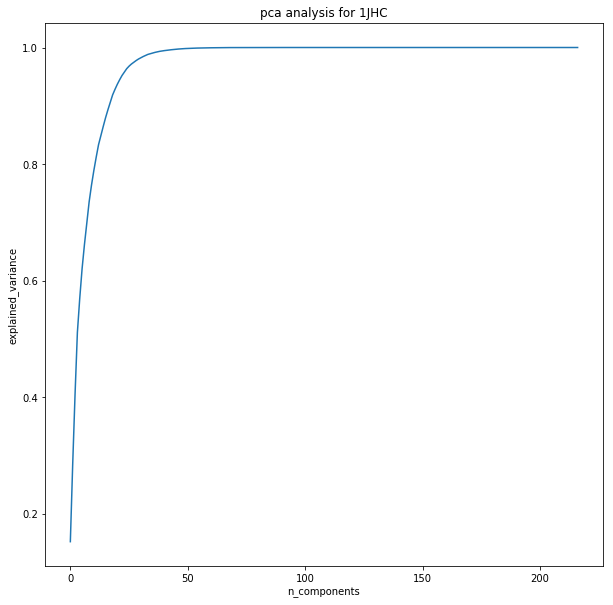

keeping 71 pca components gives more than 0.9999 variance_ratio
fraction of variance explained by the first 75 pca components is: 0.9999327895873423


In [124]:
tp='1JHC'
scaler, pca, X_train, y_train, X_val, y_val, n_features=feature_processing(tp)

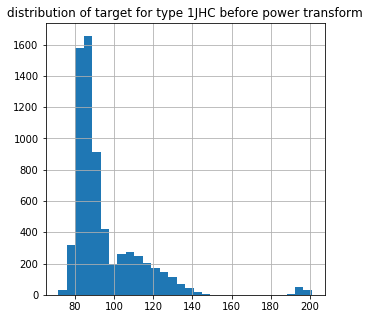

<Figure size 432x288 with 0 Axes>

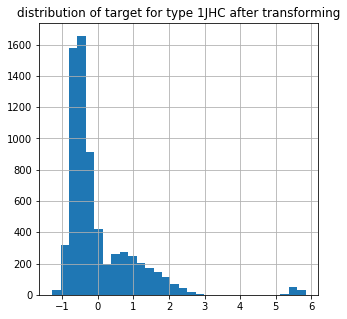

In [125]:
target_pipe=transform_target(tp)

In [126]:
y_train_trans=target_pipe.transform(y_train.reshape(-1,1)).reshape(-1,)
y_val_trans=target_pipe.transform(y_val.reshape(-1,1)).reshape(-1,)

In [127]:
print(X_train.shape)
print(X_val.shape)
print(y_train_trans.shape)
print(y_val_trans.shape)

(6755, 75)
(1645, 75)
(6755,)
(1645,)


In [128]:
# In the implementation for google colab, we included model 7 in choice_of_models here
# but it is too big for my laptop's GPU which subsequently stops and flashes OOM error
# so we will remove model 7 for the purposes of sample calculations here
models=model_ensembles(tp, n_features, X_train, y_train_trans, X_val, y_val_trans, load_saved_weights=True, verbosity=1,
                    epochs=2, batch_size=1000, min_change=0.01,
                    patience=100, choice_of_models=[1,3, 5])

generating and training model : 1, verbosity is 1
loading saved weights
Train on 6755 samples, validate on 1645 samples
Epoch 1/2
6755/6755 [==============================] - 7s 1ms/step - loss: 0.1044 - R2_score: 0.9769 - val_loss: 0.1417 - val_R2_score: 0.9689

Epoch 00001: val_loss improved from inf to 0.14171, saving model to SavedModels/v2/CHAMPS_1JHC/DNN_1_weights.best.from_scratch.hdf5
Epoch 2/2
6755/6755 [==============================] - 1s 83us/step - loss: 0.0898 - R2_score: 0.9831 - val_loss: 0.1286 - val_R2_score: 0.9727

Epoch 00002: val_loss improved from 0.14171 to 0.12858, saving model to SavedModels/v2/CHAMPS_1JHC/DNN_1_weights.best.from_scratch.hdf5
Done!!
generating and training model : 3, verbosity is 1
loading saved weights
Train on 6755 samples, validate on 1645 samples
Epoch 1/2
6755/6755 [==============================] - 6s 902us/step - loss: 0.1053 - R2_score: 0.9755 - val_loss: 0.1283 - val_R2_score: 0.9720

Epoch 00001: val_loss improved from inf to 0.12828

In [129]:
len(models)

3

training set predictions for 1-th model; the mae is: 1.5500319159943012, r2_score is: 0.9850445707537513


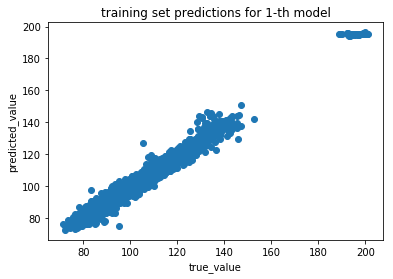

validation set predictions for 1-th model; the mae is: 2.3343341913973448, r2_score is: 0.9728945296454932


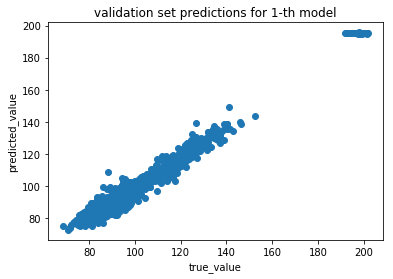

training set predictions for 2-th model; the mae is: 1.7277734837258858, r2_score is: 0.9814583940493725


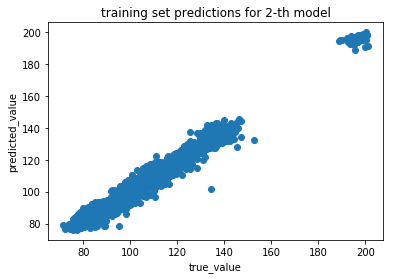

validation set predictions for 2-th model; the mae is: 2.3288588842550815, r2_score is: 0.9725111479588866


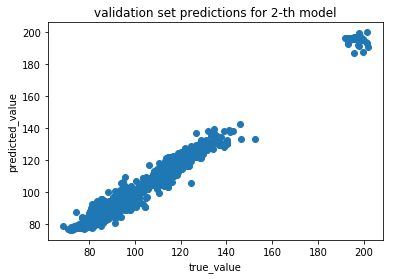

training set predictions for 3-th model; the mae is: 1.3385255591019094, r2_score is: 0.9888861573901354


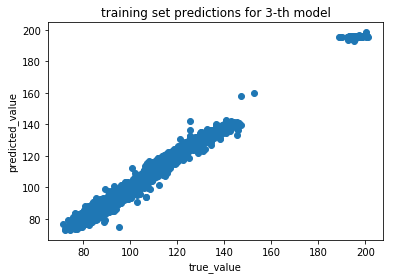

validation set predictions for 3-th model; the mae is: 2.3004388196579955, r2_score is: 0.974426866224267


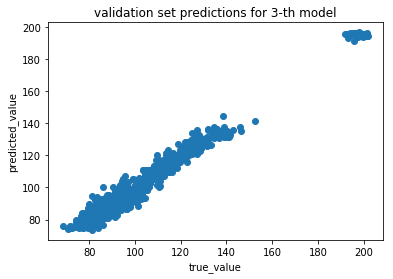

Averaged training set predictions; the mae is: 1.2435145052814984, r2_score is: 0.9904795609468685


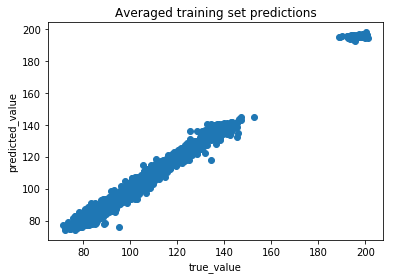

Averaged validation set predictions; the mae is: 2.0734647967278597, r2_score is: 0.978918056806268


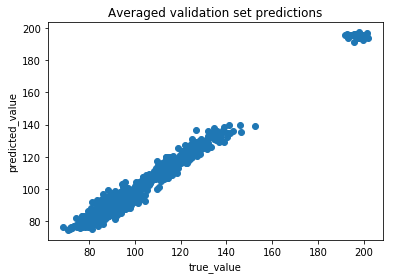

In [130]:
validation_results(X_train, y_train, X_val, y_val, models, target_pipe)

#### Predictions on the CHAMPS test set

In [131]:
# preparing test set features
test_sub, X_test=test_features(tp, scaler, pca)

Great! dat_0 for type 1JHC contains no missing entries
Great! dat_1 for type 1JHC contains no missing entries
Great! There are no Nans or infs in X_test
shape of test set feature array: (5004, 217)
shape of test set feature array after pca reduction: (5004, 75)


In [133]:
# test set predictions
y_pred=test_predictions(tp, X_test, X_val, y_val, target_pipe,  choice_of_models=[1,3,5])
test_sub['scalar_coupling_constant']=y_pred
test_sub.head()

generating and loading model : 1
loading saved weights
Done!!
generating and loading model : 3
loading saved weights
Done!!
generating and loading model : 5
loading saved weights
Done!!


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667398,dsgdb9nsd_000658,6,0,1JHC,78.767788
1,4667408,dsgdb9nsd_000658,7,0,1JHC,80.550214
2,4667418,dsgdb9nsd_000658,8,1,1JHC,78.781819
3,4667426,dsgdb9nsd_000658,9,1,1JHC,80.580927
4,4667434,dsgdb9nsd_000658,10,2,1JHC,80.567342


In [134]:
# storing the results into a file
pred_file_path=os.path.join(current_dir, 'predictions_v2', '{}_predictions.csv'.format(tp))
test_sub.to_csv(pred_file_path, index=False)

In [135]:
# checking that the file was stored properly
pred_check=pd.read_csv(pred_file_path)
pred_check.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667398,dsgdb9nsd_000658,6,0,1JHC,78.767788
1,4667408,dsgdb9nsd_000658,7,0,1JHC,80.550214
2,4667418,dsgdb9nsd_000658,8,1,1JHC,78.781819
3,4667426,dsgdb9nsd_000658,9,1,1JHC,80.580927
4,4667434,dsgdb9nsd_000658,10,2,1JHC,80.567342


# Collating all CHAMPS test predictions

In [136]:
test=pd.read_csv('test_sample.csv')

In [137]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4667398,dsgdb9nsd_000658,6,0,1JHC
1,4667399,dsgdb9nsd_000658,6,1,2JHC
2,4667400,dsgdb9nsd_000658,6,2,3JHC
3,4667401,dsgdb9nsd_000658,6,4,3JHC
4,4667402,dsgdb9nsd_000658,6,5,2JHC


In [138]:
# function to merge results of given coupling type

def merge_results(tp):
    global test
    
    file=os.path.join(current_dir, 'predictions_v2', '{}_predictions.csv'.format(tp))
    results=pd.read_csv(file)
    test=test.merge(results, how='left', left_on=['id','molecule_name','atom_index_0', 'atom_index_1', 'type'],
                right_on=['id','molecule_name','atom_index_0', 'atom_index_1', 'type'], validate='one_to_one')
    return

In [139]:
tp_lis=test.type.unique()
print(tp_lis)

['1JHC' '2JHC' '3JHC' '2JHH' '3JHH' '1JHN' '2JHN' '3JHN']


In [140]:
# merging the results
[merge_results(tp) for tp in tp_lis]

[None, None, None, None, None, None, None, None]

In [141]:
# At this point the DataFrame test contains the results from each type in seperate columns
test.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant_x,scalar_coupling_constant_y,scalar_coupling_constant_x,scalar_coupling_constant_y,scalar_coupling_constant_x,scalar_coupling_constant_y,scalar_coupling_constant_x,scalar_coupling_constant_y
0,4667398,dsgdb9nsd_000658,6,0,1JHC,78.767788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4667399,dsgdb9nsd_000658,6,1,2JHC,NaN,-1.479047,NaN,NaN,NaN,NaN,NaN,NaN
2,4667400,dsgdb9nsd_000658,6,2,3JHC,NaN,NaN,5.787985,NaN,NaN,NaN,NaN,NaN
3,4667401,dsgdb9nsd_000658,6,4,3JHC,NaN,NaN,5.789751,NaN,NaN,NaN,NaN,NaN
4,4667402,dsgdb9nsd_000658,6,5,2JHC,NaN,-1.477652,NaN,NaN,NaN,NaN,NaN,NaN
5,4667403,dsgdb9nsd_000658,6,7,2JHH,NaN,NaN,NaN,-11.746811,NaN,NaN,NaN,NaN
6,4667404,dsgdb9nsd_000658,6,8,3JHH,NaN,NaN,NaN,NaN,1.775538,NaN,NaN,NaN
7,4667405,dsgdb9nsd_000658,6,9,3JHH,NaN,NaN,NaN,NaN,2.934270,NaN,NaN,NaN
8,4667406,dsgdb9nsd_000658,6,16,3JHH,NaN,NaN,NaN,NaN,2.924609,NaN,NaN,NaN
9,4667407,dsgdb9nsd_000658,6,17,3JHH,NaN,NaN,NaN,NaN,1.755000,NaN,NaN,NaN


In [142]:
test.shape

(32918, 13)

In [143]:
# The Nans in each column corresponds to the rows whose type is different from the intended one
# we can simply replace all the nans by 0 and add all the coulumns to get the predictions for the rows in the same column
test=test.fillna(0.0)
test['scalar_coupling_constant']=np.sum(test.iloc[:,5:].values, axis=1)
test.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant_x,scalar_coupling_constant_y,scalar_coupling_constant_x,scalar_coupling_constant_y,scalar_coupling_constant_x,scalar_coupling_constant_y,scalar_coupling_constant_x,scalar_coupling_constant_y,scalar_coupling_constant
0,4667398,dsgdb9nsd_000658,6,0,1JHC,78.767788,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,78.767788
1,4667399,dsgdb9nsd_000658,6,1,2JHC,0.000000,-1.479047,0.000000,0.000000,0.000000,0.0,0.0,0.0,-1.479047
2,4667400,dsgdb9nsd_000658,6,2,3JHC,0.000000,0.000000,5.787985,0.000000,0.000000,0.0,0.0,0.0,5.787985
3,4667401,dsgdb9nsd_000658,6,4,3JHC,0.000000,0.000000,5.789751,0.000000,0.000000,0.0,0.0,0.0,5.789751
4,4667402,dsgdb9nsd_000658,6,5,2JHC,0.000000,-1.477652,0.000000,0.000000,0.000000,0.0,0.0,0.0,-1.477652
5,4667403,dsgdb9nsd_000658,6,7,2JHH,0.000000,0.000000,0.000000,-11.746811,0.000000,0.0,0.0,0.0,-11.746811
6,4667404,dsgdb9nsd_000658,6,8,3JHH,0.000000,0.000000,0.000000,0.000000,1.775538,0.0,0.0,0.0,1.775538
7,4667405,dsgdb9nsd_000658,6,9,3JHH,0.000000,0.000000,0.000000,0.000000,2.934270,0.0,0.0,0.0,2.934270
8,4667406,dsgdb9nsd_000658,6,16,3JHH,0.000000,0.000000,0.000000,0.000000,2.924609,0.0,0.0,0.0,2.924609
9,4667407,dsgdb9nsd_000658,6,17,3JHH,0.000000,0.000000,0.000000,0.000000,1.755000,0.0,0.0,0.0,1.755000


In [144]:
# drop the irrelevant data
to_drop=test.columns.values[5:13]
print(to_drop)
test.drop(columns=to_drop, inplace=True)
test.head()

['scalar_coupling_constant_x' 'scalar_coupling_constant_y'
 'scalar_coupling_constant_x' 'scalar_coupling_constant_y'
 'scalar_coupling_constant_x' 'scalar_coupling_constant_y'
 'scalar_coupling_constant_x' 'scalar_coupling_constant_y']


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,4667398,dsgdb9nsd_000658,6,0,1JHC,78.767788
1,4667399,dsgdb9nsd_000658,6,1,2JHC,-1.479047
2,4667400,dsgdb9nsd_000658,6,2,3JHC,5.787985
3,4667401,dsgdb9nsd_000658,6,4,3JHC,5.789751
4,4667402,dsgdb9nsd_000658,6,5,2JHC,-1.477652


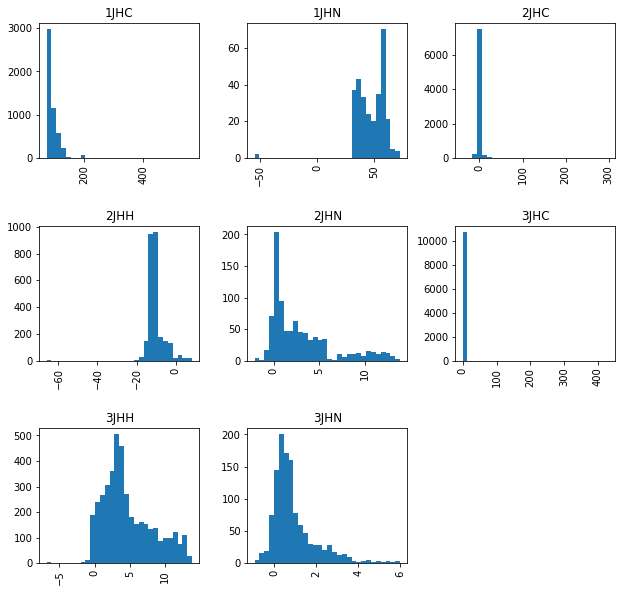

In [145]:
# distribution of predictions 
# just a minor check that the predicted values have a distribution similar to that of training set
test_his=test.hist(column='scalar_coupling_constant', by='type', figsize=(10,10), bins=30)

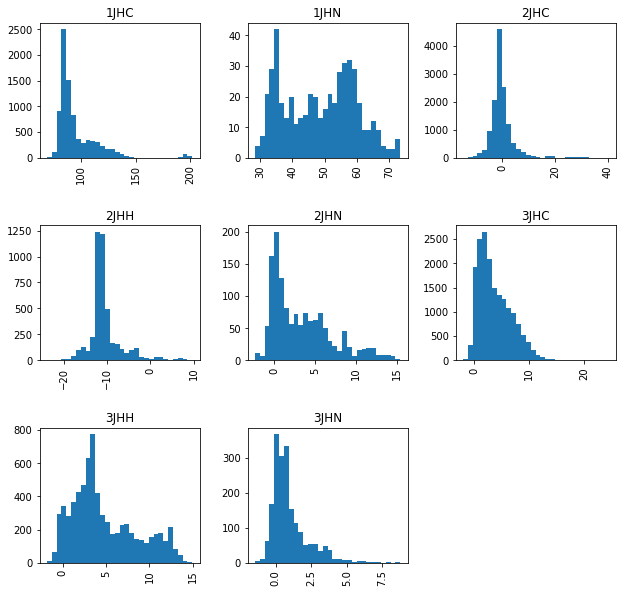

In [146]:
# training set distribution
train=pd.read_csv('train_sample.csv')
hist_grouped_by_type=train.hist( column='scalar_coupling_constant',
                                by='type', figsize=(10,10), bins=30)

In [147]:
submission=test[['id','scalar_coupling_constant']]

In [148]:
filepath=os.path.join(current_dir, 'sample_submissions', 'submission_v2.csv')
print(filepath)
submission.to_csv(filepath, index=False)

C:\Users\agarw\Downloads\udacity-mlnd-master\Capstone project\sample_submissions\submission_v2.csv


In [149]:
submission_chk=pd.read_csv(filepath)
submission_chk.head()

,id,scalar_coupling_constant
0,4667398,78.767788
1,4667399,-1.479047
2,4667400,5.787985
3,4667401,5.789751
4,4667402,-1.477652
